# ENG10007 Produção de Energia Elétrica - Curso de 2025/2
## Trabalho 1 – 2025/2 – Notebook Base (Colab)

**Autores:** _Arthur Almeida & Lucas Follmann_

**Código da estação:** _73420080_

**Nome da estação:** 	_UHE PASSO FUNDO BARRAMENTO_

**Objetivo:** Este notebook segue o edital 2025/2 para o projeto e avaliação de um aproveitamento hidrelétrico. Estrutura-se em: (1) hidrologia (incl. curva de duração e Rippl), (2) geometria do reservatório e evaporação, (3) seleção de turbinas/geradores, (4) simulação da operação e energia com cenários, e (5) validações/sensibilidades.

> **IMPORTANTE:** Os **dois últimos anos completos** do histórico **não** entram na análise hidrológica. Servirão para a simulação de operação.


## Dados & Pré-processamento
A etapa de pré-processamento garante consistência temporal e comparabilidade entre anos. A exclusão dos dois últimos anos atende ao edital (reserva para operação simulada). A caracterização estatística (média, mediana e quantis) fornece insumos para a curva de permanência e para a síntese hidrológica.
**Passos**
1. Carregar série histórica via planilha retirada no site da ANA.
2. Checar e tratar ausências/outliers.
3. Construir agregações mensal.
4. **Separar os dois últimos anos completos** (hold-out) para a simulação da operação.
5. Calcular a **vazão média de longo termo**; se fora de 30–60 m³/s, **aplicar fator multiplicativo** e registrar.

**Entradas**
- Histórico de vazões em m³/s;
- Foram removidos todos os dados que tinham o valor vazão "0";
- Foram removidos todos os dados que excediam/eram inferiores ao valor médio +/-3 desvios padrões;
- Foram removidos os meses que possuíam 5 ou mais dias sem dados coletados ou removidos durante a filtragem;
- A média de todos os dados de vazão resultou em 62.6688 m³/s. Para atender a restrição do problema, todos os valores foram multiplicados por 60/63.


## 1) Setup
- Instalação/importação de bibliotecas;
- Configurações gerais de gráficos;
- Definições úteis (constantes físicas, caminhos);
- Planilhas com vazão já pré-processadas retiradas do GitHub.


In [ ]:
# @title
# ==== Imports ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import files
import matplotlib.dates as mdates

#Importar arquivo do GITHUB
# URL do arquivo raw no GitHub, arquivo filtrado sem os últimos 2 anos
url = "https://raw.githubusercontent.com/ArthurAlmeida00/repositorio_t1_producao_energia/main/73420080_Vazoes%20_filtrado.xlsx"
df = pd.read_excel(url)
df.head()

url2 = "https://raw.githubusercontent.com/ArthurAlmeida00/repositorio_t1_producao_energia/main/73420080_Vazoes_2anos.xlsx"
df2 = pd.read_excel(url2)

# ==== Configurações ====
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True

# ==== Constantes ====
RHO = 1000.0  # kg/m³ #Densidade da água usado no cálculo da potência hidráulica
G = 9.81      # m/s²  #Aceleração da gravidade
SEG_DIA = 86400.0



## 2) Curva de persistência
**O que foi feito:** A partir das vazões diárias do histórico (sem os 2 últimos anos), é ordenado de maior para menor e traçado a curva de permanência, destacando Q5, Q50 e Q95 e a vazão média.

 A curva de permanência expressa a frequência com que uma vazão é igualada ou excedida. Pontos de referência:
- Q5: regime úmido (vazões altas, baixa permanência);
- Q50: mediana do regime;
- Q95: regime de estiagem (vazões baixas, alta permanência).

Esses valores embasam a definição de vazão de projeto

Alguns trechos de código foram configurados para exibir apenas os resultados essenciais à análise, de modo a manter o notebook mais limpo e objetivo. No entanto, é possível inspecionar o funcionamento interno de cada rotina realizando pequenas alterações, como incluir comandos de impressão, de forma a visualizar os valores intermediários na tela.


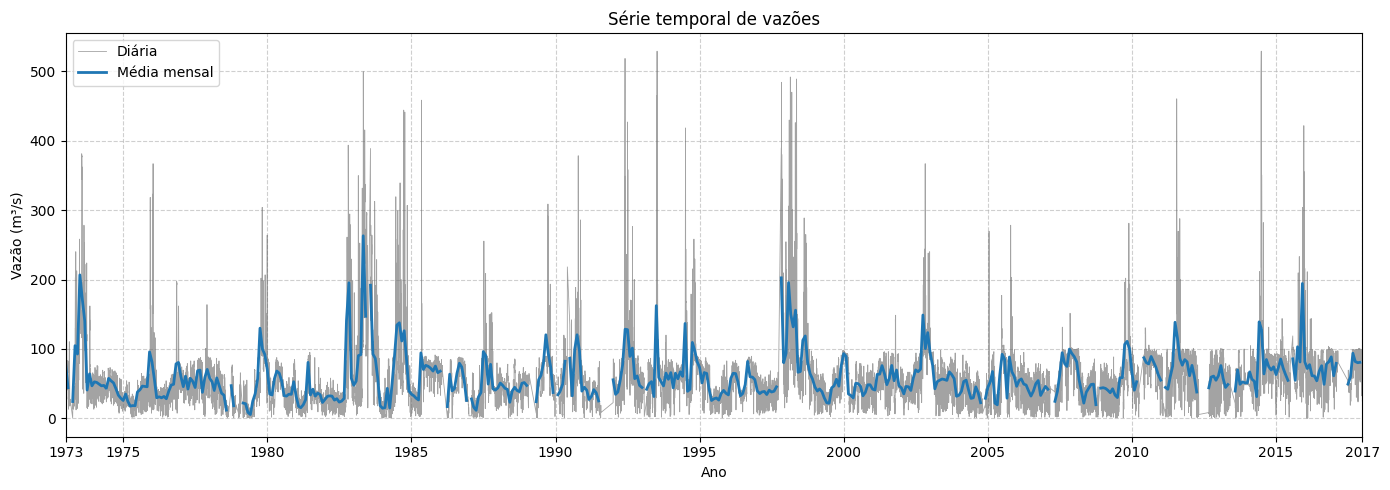

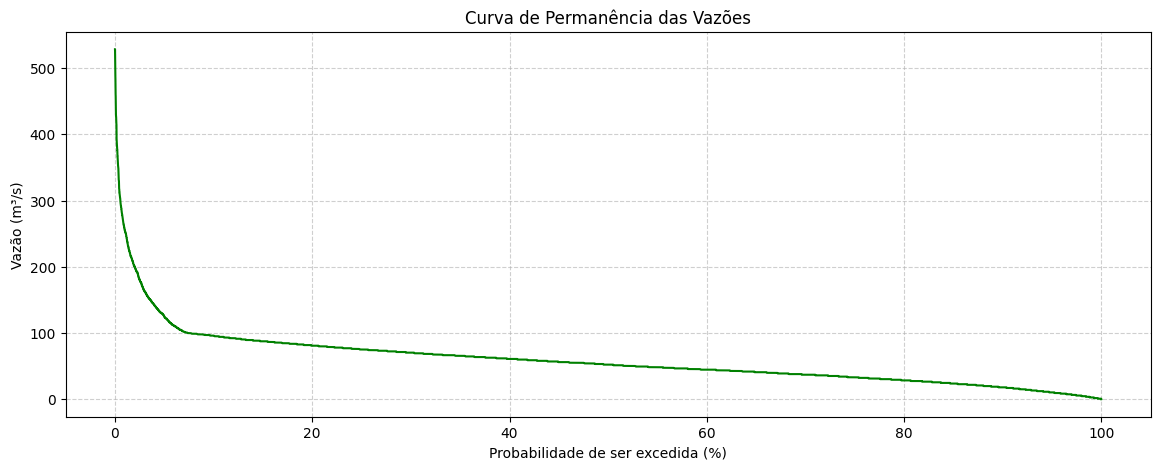

In [ ]:
# @title 2.1) Análise Exploratória de Vazões e Visualização
# @markdown Este bloco carrega os dados brutos de vazão, reestrutura o formato da tabela e, por fim, gera os dois gráficos essenciais para a compreensão do regime hidrológico: a **Série Temporal** e a **Curva de Permanência**.

# @markdown ---

# @markdown ## i. Descrição do Processamento dos Dados
# @markdown Esta seção detalha as etapas executadas pelo código para converter os dados brutos da planilha em um formato de série temporal para análise.

# @markdown - **Leitura e Transformação de Formato:** O código lida com o formato de calendário anual (*wide*) da planilha (meses x dias) e o transforma no formato de série temporal (*long*), que é o padrão para análise hidrológica. A função `pd.melt` é crucial para esta reestruturação.
# @markdown - **Construção da Data:** A data final correta é gerada pela combinação da data base da planilha com o deslocamento de dia extraído do nome da coluna (ex: "Vazao05").
# @markdown - **Limpeza:** Dados nulos (`NaN`) são removidos via `dropna` para garantir a integridade e continuidade da série.

# @markdown ---

# @markdown ## ii. Discussão dos Resultados Gráficos

# @markdown ### Série temporal de vazões
# @markdown O gráfico apresenta a evolução das vazões ao longo de mais de quatro décadas. A linha cinza mostra a série diária (curta variabilidade e picos de cheia), e a linha azul (média mensal) destaca a **sazonalidade anual** e eventuais **tendências interanuais** de longo prazo.
# @markdown **Ponto Crítico:** É crucial que não se assuma a **estacionariedade** do regime hidrológico, dado o longo período de observação e o contexto de alterações climáticas.

# @markdown ### Curva de permanência das vazões
# @markdown O gráfico mostra a probabilidade de uma vazão ser igualada ou excedida, definindo os quantis críticos:
# @markdown - **Q5 (Cheia):** Vazão de alta raridade (5% de chance de ser excedida). Fundamental para o dimensionamento do **vertedouro** e segurança estrutural.
# @markdown - **Q50 (Média):** Representa o potencial **médio de geração** do aproveitamento.
# @markdown - **Q95 (Estiagem):** Vazão de baixa frequência. Essencial para avaliar a **segurança energética** e a capacidade de **regularização do reservatório**.
#====CÓDIGO====
#1. Ler o arquivo csv do upload do setup, pulando linhas de comentários
df = pd.read_excel(url, skiprows=15)

# 2. Selecionar apenas colunas de interesse
# Mantemos a primeira coluna ("Data") e todas as que começam com "Vazao"
cols = ["Data"] + [c for c in df.columns if c.startswith("Vazao") and not c.endswith("Status")]
df = df[cols]

# 3. Transformar formato wide -> long
df_long = df.melt(id_vars=["Data"], var_name="Dia", value_name="Vazao")

# Extrair número do dia da coluna (ex.: "Vazao05" -> 5)
df_long["Dia"] = df_long["Dia"].str.extract(r'(\d+)').astype(int)

# Criar data real (Data_base + deslocamento de dias)
df_long["Data"] = pd.to_datetime(df_long["Data"]) + pd.to_timedelta(df_long["Dia"]-1, unit="D")

# 4. Tratar valores vazios
df_long = df_long.dropna(subset=["Vazao"])  # remove NaN
# (opcional) para interpolar em vez de remover:
# df_long["Vazao"] = df_long["Vazao"].interpolate()

# Ordenar por data
df_long = df_long.sort_values("Data")

# Gráfico da série temporal
# --- série mensal para suavizar ---
df_mensal = (df_long
             .set_index('Data')['Vazao']
             .resample('MS').mean()
             .rename('Q_m_m3s')
             .reset_index())

fig, ax = plt.subplots(figsize=(14,5))

# diária: fina e cinza claro (ruído reduzido)
ax.plot(df_long['Data'], df_long['Vazao'],
        linewidth=0.6, alpha=0.6, color='0.4', label='Diária')

# mensal: destaque por cima
ax.plot(df_mensal['Data'], df_mensal['Q_m_m3s'],
        linewidth=2.0, color='tab:blue', label='Média mensal')

# limites exatamente nos dados (sem bordas brancas)
data_min = pd.to_datetime(df_long['Data'].min())
data_max = pd.to_datetime(df_long['Data'].max())
ax.set_xlim(data_min, data_max)
ax.margins(x=0)

# ticks de 5 em 5 anos + garantir 1º e último ano
start_year = data_min.year
end_year   = data_max.year
first5 = ((start_year + 4)//5)*5
years5 = list(range(first5, end_year+1, 5))
tick_dates = [data_min] + [pd.Timestamp(y,1,1) for y in years5] + [data_max]
tick_dates = sorted(pd.to_datetime(list(dict.fromkeys(tick_dates))))
ax.set_xticks(tick_dates)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# estética
ax.set_title('Série temporal de vazões')
ax.set_xlabel('Ano')
ax.set_ylabel('Vazão (m³/s)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()


# 6. Curva de permanência
vazoes = df_long["Vazao"].sort_values(ascending=False).reset_index(drop=True) # Corrected column name here
n = len(vazoes)
prob_exced = np.arange(1, n+1) / (n+1) * 100

plt.figure(figsize=(14,5))
plt.plot(prob_exced, vazoes, color="green")
plt.xlabel("Probabilidade de ser excedida (%)")
plt.ylabel("Vazão (m³/s)")
plt.title("Curva de Permanência das Vazões")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



In [ ]:
# @title 2.2) Amostra de dados de um ano específico
# @markdown Este célula filtra e mostra apenas as medições de vazão de um ano escolhido.
# @markdown Isso permite conferir se os dados foram carregados corretamente e observar o comportamento da série nesse período.

# Especifique o ano que você deseja filtrar
ano_desejado = 2010  # Altere este valor para o ano desejado

# Filtrar o DataFrame para o ano especificado
df_ano_especifico = df_long[df_long['Data'].dt.year == ano_desejado]

# print(f"Dados de Vazão para o ano {ano_desejado}:")
# print(df_ano_especifico[["Data", "Vazao"]].to_string(index=False))


In [ ]:
# @title 2.3) Contador do número total de medições
# @markdown Esta célula conta quantos registros de vazão existem no DataFrame `df_long`.
# @markdown O resultado indica o tamanho da série histórica após o pré-processamento.

numero_medidas = len(df_long)

# print(f"O número total de medidas no DataFrame é: {numero_medidas}")


In [ ]:
# @title 2.4) Estatísticas anuais de vazão
# @markdown Esta célula calcula estatísticas descritivas das vazões, permitindo selecionar:
# @markdown - Um único ano específico, ou
# @markdown - Uma faixa de anos consecutivos.
# @markdown Assim, é possível comparar médias, máximos e mínimos da série em diferentes períodos.

# --- Opções do usuário ---
# ano_unico = 2010              # escolha um ano específico
# ano_inicio, ano_fim = 2000, 2017   # ou escolha uma faixa de anos

# --- Um único ano ---
# df_ano = df_long[df_long['Data'].dt.year == ano_unico]
# if not df_ano.empty:
#     print(f"\nEstatísticas descritivas para as vazões no ano {ano_unico}:")
#     print(df_ano['Vazao'].describe())
# else:
#     print(f"\n⚠️ Nenhum dado encontrado para {ano_unico}")

# --- Uma faixa de anos ---
# df_faixa = df_long[(df_long['Data'].dt.year >= ano_inicio) & (df_long['Data'].dt.year <= ano_fim)]
# if not df_faixa.empty:
#     print(f"\nEstatísticas descritivas para a faixa {ano_inicio}–{ano_fim}:")
#     print(df_faixa['Vazao'].describe())
# else:
#     print(f"\n⚠️ Nenhum dado encontrado entre {ano_inicio}–{ano_fim}")


In [ ]:
# @title 2.5) Contagem de registros por ano
# @markdown Está célula adiciona uma coluna com o ano de cada medição,
# @markdown conta quantos registros existem em cada ano e organiza o resultado em ordem cronológica.
# @markdown Isso permite verificar a consistência da série histórica e identificar possíveis lacunas.

df_long['Ano'] = df_long['Data'].dt.year

# Contar o número de medidas por ano
medidas_por_ano = df_long['Ano'].value_counts().sort_index()

# print("Número de medidas de vazão por ano:")
# print(medidas_por_ano.to_string())

# Remover a coluna 'Ano' temporária se não for mais necessária
df_long = df_long.drop(columns=['Ano'])


In [ ]:
# @title 2.6) Estatísticas descritivas das vazões por ano e gerais
# @markdown Esta célula gera estatísticas descritivas das vazões (média, desvio, mínimos, máximos, etc.),
# @markdown agrupadas por ano e também para toda a série histórica.
# @markdown Isso permite comparar a variabilidade anual com o comportamento global da bacia.

# Agrupar por ano e calcular estatísticas descritivas para cada ano
estatisticas_por_ano = df_long.groupby(df_long['Data'].dt.year)['Vazao'].describe()

# Calcular estatísticas descritivas para todas as vazões
estatisticas_gerais = df_long['Vazao'].describe()

# Adicionar as estatísticas gerais como uma nova linha
estatisticas_por_ano.loc['Geral'] = estatisticas_gerais

# Exibir formatando: count sem decimais, o resto com 3 casas
format_dict = {col: "{:.3f}" for col in estatisticas_por_ano.columns}
format_dict['count'] = "{:.0f}"  # sem casas decimais no count

# print("Estatísticas descritivas das vazões por ano e gerais:")
# display(estatisticas_por_ano.style.format(format_dict))


In [ ]:
# @title 2.7) Estatísticas descritivas mensais de vazão - Ano sintético

# @title Lógica do Cálculo do Ano Sintético (Estatísticas Mensais)
# @markdown Esta célula realiza o cálculo das estatísticas descritivas (média, desvio-padrão, quartis, etc.) para cada mês do ano, consolidando mais de quatro décadas de observações em um **"Ano Sintético"** representativo.

# @markdown ### Como o cálculo é realizado:
# @markdown 1.  **Agrupamento por Mês:** A função `df_long.groupby(df_long['Data'].dt.month)` agrupa todos os registros de vazão (que estão na série temporal completa) pelo seu respectivo **mês calendário** (Janeiro = 1, Fevereiro = 2, etc.).
# @markdown 2.  **Cálculo Estatístico:** O método `.describe()` é aplicado a cada um desses 12 grupos. Ele calcula simultaneamente o **volume de dados** (`count`), a **vazão média** (`mean`), a **variabilidade** (`std`) e os principais **quantis** (mínimo, 25%, 50%, 75%, máximo) para aquele mês, usando todos os anos da série.
# @markdown 3.  **Resultado:** A tabela final (Ano Sintético) mostra o comportamento **típico** de vazão para cada mês, o que é fundamental para o **dimensionamento do reservatório** e o planejamento da operação. A linha 'Geral' resume as estatísticas da série completa.
# @markdown ---
# @markdown ### Objetivo do Ano Sintético
# @markdown O **Ano Sintético** é a representação estatística do **regime hidrológico típico** da bacia. Ele elimina as variações anuais extremas (anos muito secos ou muito úmidos) para focar na **sazonalidade média de longo prazo**.
# @markdown - **Dimensionamento:** As vazões médias mensais são a base para determinar a **potência firme** (garantida) da usina e definir a vazão de projeto das turbinas.
# @markdown - **Planejamento de Estoque:** As estatísticas mensais (mínimos, máximos e desvio-padrão) são essenciais para planejar a **capacidade de armazenamento** necessária do reservatório, garantindo o atendimento energético durante os períodos de **estiagem média** (meses de vazões mínimas) e gerenciando riscos de cheia.
# @markdown - **Referência Operacional:** Serve como referência neutra para comparar o desempenho de um ano específico (se ele está acima ou abaixo da média histórica).
# Agrupar por mês e calcular estatísticas
estatisticas_por_mes = df_long.groupby(df_long['Data'].dt.month)['Vazao'].describe()

# Se estatisticas_gerais não existir ainda, calcule:
# estatisticas_gerais = df_long['Vazao'].describe()
estatisticas_por_mes.loc['Geral'] = estatisticas_gerais

# Formatação: count sem casas decimais, os outros com 3
format_dict = {col: "{:.3f}" for col in estatisticas_por_mes.columns}
format_dict['count'] = "{:.0f}"  # sem casas decimais no count

print("Estatísticas descritivas das vazões por mês e gerais:")
display(estatisticas_por_mes.style.format(format_dict))


Estatísticas descritivas das vazões por mês e gerais:


,count,mean,std,min,25%,50%,75%,max
Data,,,,,,,,
1,1315,54.732,31.034,0.476,34.286,51.429,71.429,366.667
2,1128,53.176,39.538,0.159,31.429,47.619,67.619,491.429
3,1231,50.261,33.986,0.952,27.619,48.571,65.714,469.524
4,1219,45.232,32.979,0.952,21.905,43.810,61.905,425.714
5,1287,54.960,53.164,0.952,27.619,44.762,68.571,518.095
6,1219,54.840,45.687,0.952,28.571,43.810,70.476,528.571
7,1254,66.065,60.741,0.952,34.286,51.905,77.143,528.571
8,1325,65.446,46.369,0.952,38.095,57.143,82.857,388.571
9,1279,65.450,42.612,0.952,39.048,59.048,83.810,443.810


## 3) Hidrologia: Fluviogramas, Curva de Permanência e Diagrama de Rippl
Esta seção transforma a série histórica de vazões em parâmetros essenciais de engenharia. A análise é realizada exclusivamente com a série de longo prazo ajustada, excluindo os dados dos dois últimos anos (2018 e 2019, reservados para a simulação de operação).
O objetivo é caracterizar o regime hidrológico, quantificar a frequência das vazões e dimensionar o volume de regularização do reservatório.
### Fluviogramas (diário e mensal)
Propósito: Geração dos gráficos de médias diárias (variabilidade bruta) e mensais (sazonalidade) para a caracterização visual do regime. Esta análise preliminar confirma os períodos úmidos e secos, e permite uma primeira inspeção de possíveis tendências de longo prazo.

### Curva de Permanência (Duração)
Propósito: Quantificação da frequência de ocorrência das vazões. A curva é gerada ordenando as vazões da série histórica e calculando a probabilidade de excedência.
- Parametros extraídos: Serão extraídos e documentados as vazões rdena as vazões **Q5**, **Q50** e **Q95**.

### Diagrama de Rippl (mensal)
Propósito: Dimensionamento do Volume Útil do Reservatório. Com base nas afluências médias mensais (ano sintético) e na vazão de projeto  diagrama de Rippl determina o volume de armazenamento mínimo necessário para garantir essa vazão constante.


<Figure size 900x500 with 0 Axes>

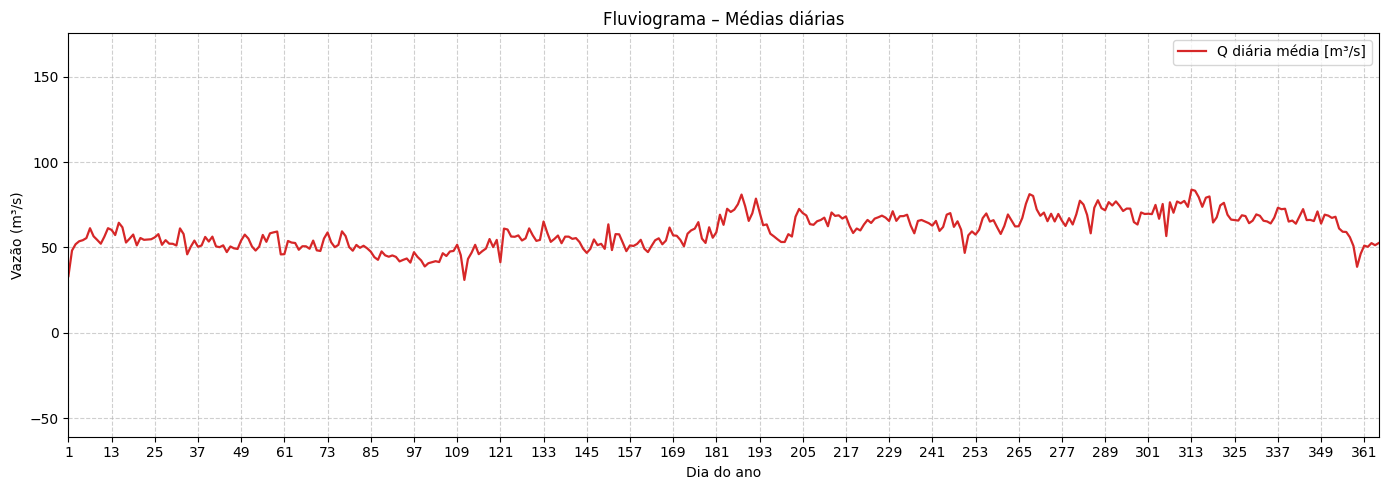

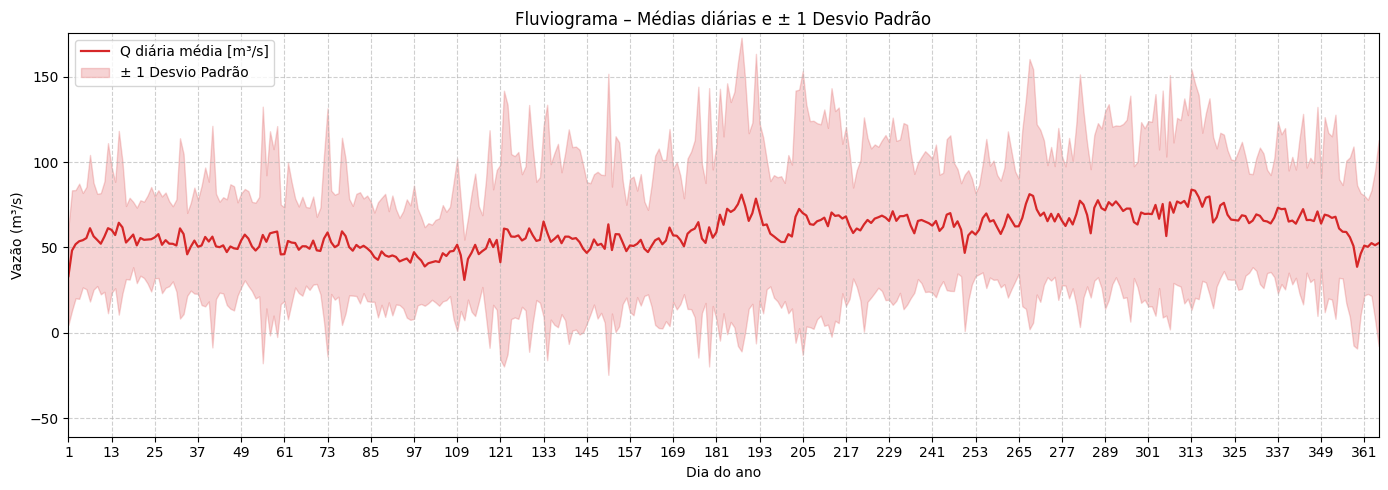

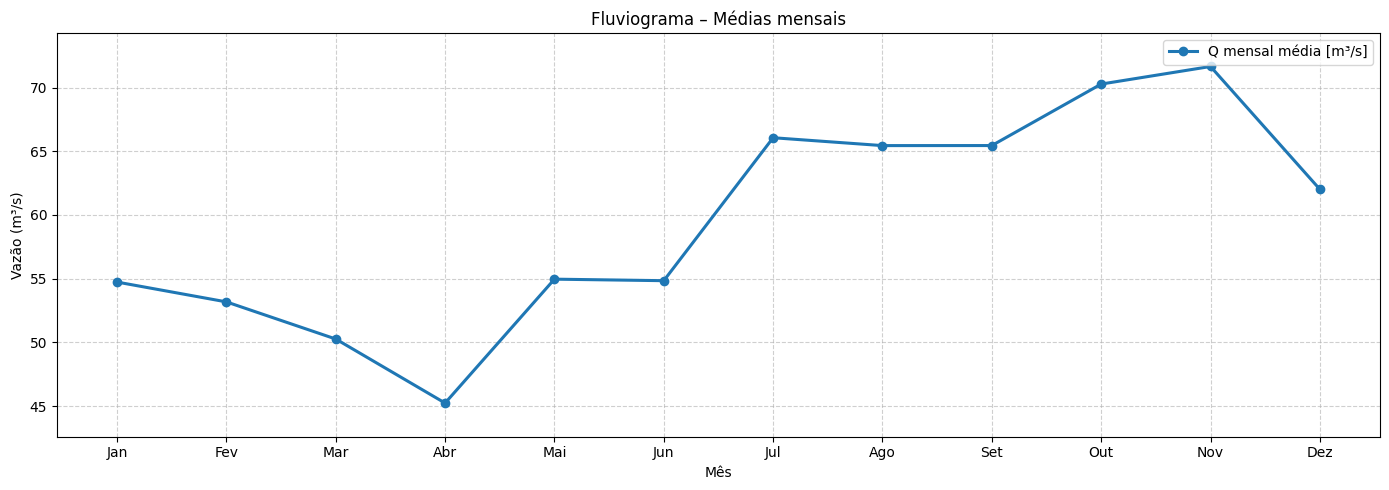

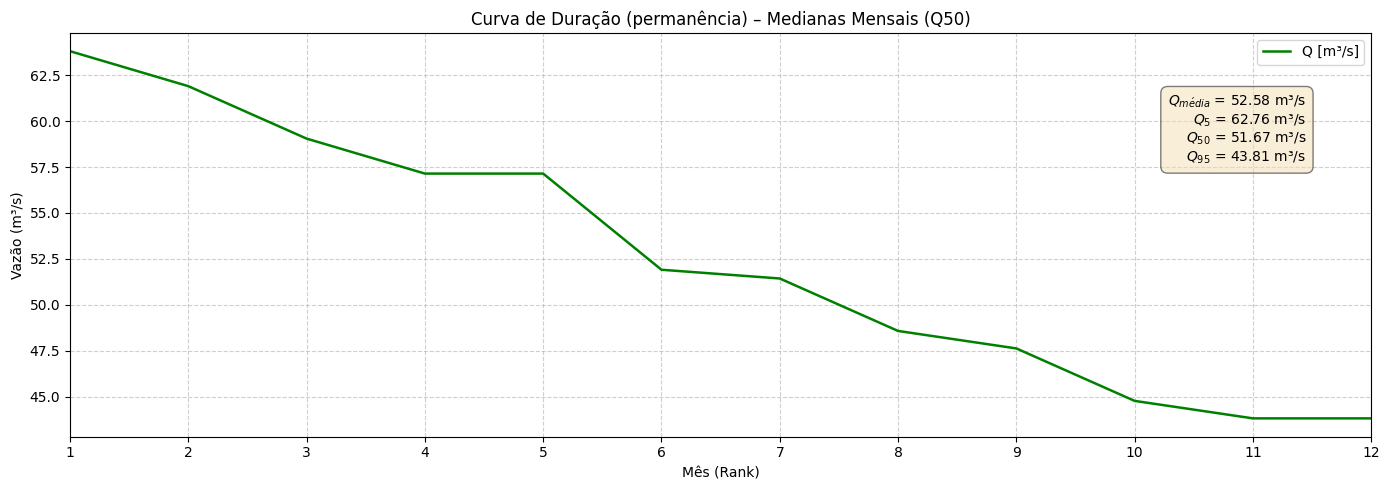

Qmédia = 52.58 m³/s | Q5 = 62.76 m³/s | Q50 = 51.67 m³/s | Q95 = 43.81 m³/s


In [ ]:
# @title 3.1) Análise do Regime e Fluviogramas (Diário vs. Mensal)
# @markdown Esta célula gera os fluviogramas (diário e mensal) e a curva de duração (permanência) a partir das médias de longo prazo.

# @markdown ---

# @markdown ## i. Descrição dos Cálculos (O que foi feito)
# @markdown O código realiza a **Climatologia** da série histórica, agrupando os dados de vazão (que excluem os dois últimos anos) para obter as estatísticas representativas de cada dia (1..365) e cada mês (Janeiro a Dezembro).
# @markdown - **Fluviograma Diário:** Calcula a média e o desvio padrão da vazão para cada um dos 365 dias do ano (excluindo 29/Fev), usando todos os anos da série.
# @markdown - **Fluviograma Mensal:** Calcula a média e o desvio padrão da vazão para cada um dos 12 meses do ano.
# @markdown - **Curva de Duração:** É gerada a partir das **12 médias mensais climatológicas**, ordenadas de forma decrescente. Os quantis $Q_{5}$, $Q_{50}$ e $Q_{95}$ são extraídos desta série mensal.

# @markdown ---

# @markdown ## ii. Discussão dos Resultados Gráficos
# @markdown ### Fluviograma Diário (Descarte)
# @markdown O Fluviograma Diário (com sombreamento de ± 1 Desvio Padrão) revela uma **variabilidade grande**. O desvio padrão é muito alto em relação à média diária, indicando que a vazão em um dia específico **flutua drasticamente** entre os anos. Devido a esse **alto ruído estatístico**, a climatologia diária não é adequada para o dimensionamento do reservatório.

# @markdown ### Fluviograma Mensal (Escolha)
# @markdown A agregação dos dados em **médias mensais** (Fluviograma Mensal) suaviza a variabilidade de curto prazo e realça o **padrão sazonal recorrente**. Este padrão é o "Ano Sintético" e é a base mais confiável para o dimensionamento e a simulação de operação, conforme preconizado em projetos de aproveitamento hidrelétrico.

# @markdown ### Curva de Duração (Permanência)
# @markdown A curva confirma a frequência das vazões e permite a extração precisa dos parâmetros de projeto:
# @markdown - **$Q_{5}$ (Vazão de Cheia):** Vazão excedida apenas 5% do tempo. Essencial para o projeto de segurança do **vertedouro**.
# @markdown - **$Q_{50}$ (Vazão Mediana):** Vazão excedida metade do tempo. Serve como referência primária para a definição da **vazão de projeto** das turbinas.
# @markdown - **$Q_{95}$ (Vazão de Estiagem):** Vazão excedida 95% do tempo. Limite inferior para a avaliação da **segurança energética** e da necessidade de armazenamento.

# calcular média por dia do ano (climatologia diária)
# remove NaN and 29/fev antes de calcular a média por dia
df_daily = (df_long.set_index('Data')['Vazao']
            .resample('D').mean())

df_daily = df_daily.dropna()
is_feb29 = (df_daily.index.month == 2) & (df_daily.index.day == 29)
df_daily = df_daily[~is_feb29]

# Média por dia do ano (1 a 365)
media_diaria = df_daily.groupby([df_daily.index.month, df_daily.index.day]).mean()
# Cria um MultiIndex de referência para os 365 dias do ano (não bissexto)
ref_index = pd.MultiIndex.from_product([range(1, 13), range(1, 32)], names=['month', 'day'])
# Reindexa para garantir 365 dias, preenchendo com NaN onde não há dados (ex: 31 fev)
media_diaria = media_diaria.reindex(ref_index).dropna()
# Reset index para ter dias 1..365 para o plot
media_diaria.index = range(1, len(media_diaria) + 1)


vals = media_diaria.values   # usa a série de 365 valores médios
n = len(vals)  # deve ser 365

# Ordena do maior para o menor
v_sorted = np.sort(vals)[::-1]

# plot
#fig, ax = plt.subplots(figsize=(14,5))
ax.plot(media_diaria.index, media_diaria.values,
        linewidth=1.6, color='tab:red', label='Q diária [m³/s]')

# eixo X de 1..365, ticks de 12 em 12 como na sua imagem
ax.set_xticks(np.arange(1, 366, 12))
ax.set_xlim(1, 365)

ax.set_title('Fluviograma – Médias diárias')
ax.set_xlabel('Dia do ano')
ax.set_ylabel('Vazão (m³/s)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

# FLUVIOGRAMA DIARIO

# calcular média e variância por dia do ano (climatologia diária)
# remove NaN and 29/fev before calculating
df_daily = (df_long.set_index('Data')['Vazao']
            .resample('D').mean())

df_daily = df_daily.dropna()
is_feb29 = (df_daily.index.month == 2) & (df_daily.index.day == 29)
df_daily = df_daily[~is_feb29]

# Média e variância por dia do ano (1 a 365)
daily_stats = df_daily.groupby([df_daily.index.month, df_daily.index.day]).agg(['mean', 'var'])

# Cria um MultiIndex de referência para os 365 dias do ano (não bissexto)
ref_index = pd.MultiIndex.from_product([range(1, 13), range(1, 32)], names=['month', 'day'])
# Reindexa para garantir 365 dias, preenchendo com NaN onde não ha dados (ex: 31 fev)
daily_stats = daily_stats.reindex(ref_index).dropna()

# Reset index to have days 1..365 for the plot
daily_stats.index = range(1, len(daily_stats) + 1)

media_diaria = daily_stats['mean']
variancia_diaria = daily_stats['var']
std_diaria = np.sqrt(variancia_diaria) # Calculate standard deviation

# Determine the common y-axis limits for daily plots
y_min_daily = min(media_diaria.min() - std_diaria.max(), media_diaria.min())
y_max_daily = max(media_diaria.max() + std_diaria.max(), media_diaria.max())


# Plot only the daily mean
fig1, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(media_diaria.index, media_diaria.values,
        linewidth=1.6, color='tab:red', label='Q diária média [m³/s]') # Changed color to red

# eixo X de 1..365, ticks de 12 em 12 como na sua imagem
ax1.set_xticks(np.arange(1, 366, 12))
ax1.set_xlim(1, 365)
ax1.set_ylim(y_min_daily, y_max_daily) # Set the same y-axis limits

ax1.set_title('Fluviograma – Médias diárias')
ax1.set_xlabel('Dia do ano')
ax1.set_ylabel('Vazão (m³/s)')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()
plt.tight_layout()
plt.show()


# plot daily mean and std dev
fig2, ax2 = plt.subplots(figsize=(14,5))

# diária: fina e cinza claro (ruído reduzido)
ax2.plot(media_diaria.index, media_diaria.values,
        linewidth=1.6, color='tab:red', label='Q diária média [m³/s]')

# Add shaded area for variance (using standard deviation for bounds)
ax2.fill_between(media_diaria.index, media_diaria - std_diaria, media_diaria + std_diaria, color='tab:red', alpha=0.2, label='± 1 Desvio Padrão')


# eixo X de 1..365, ticks de 12 em 12 como na sua imagem
ax2.set_xticks(np.arange(1, 366, 12))
ax2.set_xlim(1, 365)
ax2.set_ylim(y_min_daily, y_max_daily) # Set the same y-axis limits


ax2.set_title('Fluviograma – Médias diárias e ± 1 Desvio Padrão') # Updated title
ax2.set_xlabel('Dia do ano')
ax2.set_ylabel('Vazão (m³/s)')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()
plt.tight_layout()
plt.show()


#FLUVIOGRAMA MEDIA MENSAL
# média de todos os janeiros, fevereiros, ... (ignora meses sem dado)
monthly_stats = (df_long
                .dropna(subset=['Vazao'])
                .groupby(df_long['Data'].dt.month)['Vazao']
                .agg(['mean', 'var']))

media_mensal = monthly_stats['mean']
variancia_mensal = monthly_stats['var']
std_mensal = np.sqrt(variancia_mensal) # Calculate standard deviation


meses = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']
x = [m for m in range(1,13) if m in monthly_stats.index]  # só os meses existentes
y = [media_mensal.loc[m] for m in x]

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(x, y, linewidth=2.2, color='tab:blue', marker='o', label='Q mensal média [m³/s]')

# Remove shaded area for variance (using standard deviation for bounds)
# Need to align the x-values with the monthly stats index
# std_mensal_aligned = [std_mensal.loc[m] for m in x]
# ax.fill_between(x, np.array(y) - np.array(std_mensal_aligned), np.array(y) + np.array(std_mensal_aligned), color='tab:blue', alpha=0.2, label='± 1 Desvio Padrão')

# Adjust y-axis scale for monthly plot (add some padding)
y_min_monthly = media_mensal.min() - (media_mensal.max() - media_mensal.min()) * 0.1
y_max_monthly = media_mensal.max() + (media_mensal.max() - media_mensal.min()) * 0.1
ax.set_ylim(y_min_monthly, y_max_monthly)


ax.set_xticks(range(1,13))
ax.set_xticklabels(meses)
ax.set_title('Fluviograma – Médias mensais') # Updated title
ax.set_xlabel('Mês')
ax.set_ylabel('Vazão (m³/s)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

# CURVA DE DURAÇÃO
# === Curva de duração (permanência) – a partir dos 12 valores do ANO SINTÉTICO Q50 ===

# ATENÇÃO: É ESSENCIAL que a variável Q50, contendo as 12 Medianas Mensais (obtidas
# na sua seção de Estatísticas/Rippl) esteja definida e acessível nesta célula.

# --- CORREÇÃO: Usar os 12 valores do Q50 (Mediana Mensal) ---
vals = Q50.values # Usamos a Mediana Mensal (Q50) para manter a coerência metodológica do projeto
n = len(vals)  # n é 12 (os 12 meses)

# Ordena do maior para o menor
v_sorted = np.sort(vals)[::-1]

# Estatísticas pedidas (Calculadas sobre a série de 12 medianas)
Q_media = float(np.nanmean(vals))
Q50_plot   = float(np.percentile(vals, 50))   # Excedida 50% do tempo (Valor Mediano da série de 12 Q50)
Q95_plot   = float(np.percentile(vals, 5))    # Excedida 95% do tempo (O Q5 da Curva de Duração)
Q5_plot    = float(np.percentile(vals, 95))   # Excedida 5% do tempo (O Q95 da Curva de Duração)

# Plot
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(range(1, n+1), v_sorted, color='green', linewidth=1.8, label='Q [m³/s]')

# Eixo 1..12 (Ranks dos meses)
ax.set_xlim(1, n)
ax.set_xticks(range(1, n+1))

# Grade e rótulos
ax.set_title('Curva de Duração (permanência) – Medianas Mensais (Q50)')
ax.set_xlabel('Mês (Rank)')
ax.set_ylabel('Vazão (m³/s)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc='upper right')

# Add Q_media, Q5, Q50 and Q95 values as text annotations on the plot
ax.text(0.95, 0.85, f'$Q_{{m\\acute{{e}}dia}}$ = {Q_media:.2f} m³/s\n$Q_{{5}}$ = {Q5_plot:.2f} m³/s\n$Q_{{50}}$ = {Q50_plot:.2f} m³/s\n$Q_{{95}}$ = {Q95_plot:.2f} m³/s',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))


plt.tight_layout()
plt.show()

print(f'Qmédia = {Q_media:.2f} m³/s | Q5 = {Q5_plot:.2f} m³/s | Q50 = {Q50_plot:.2f} m³/s | Q95 = {Q95_plot:.2f} m³/s')

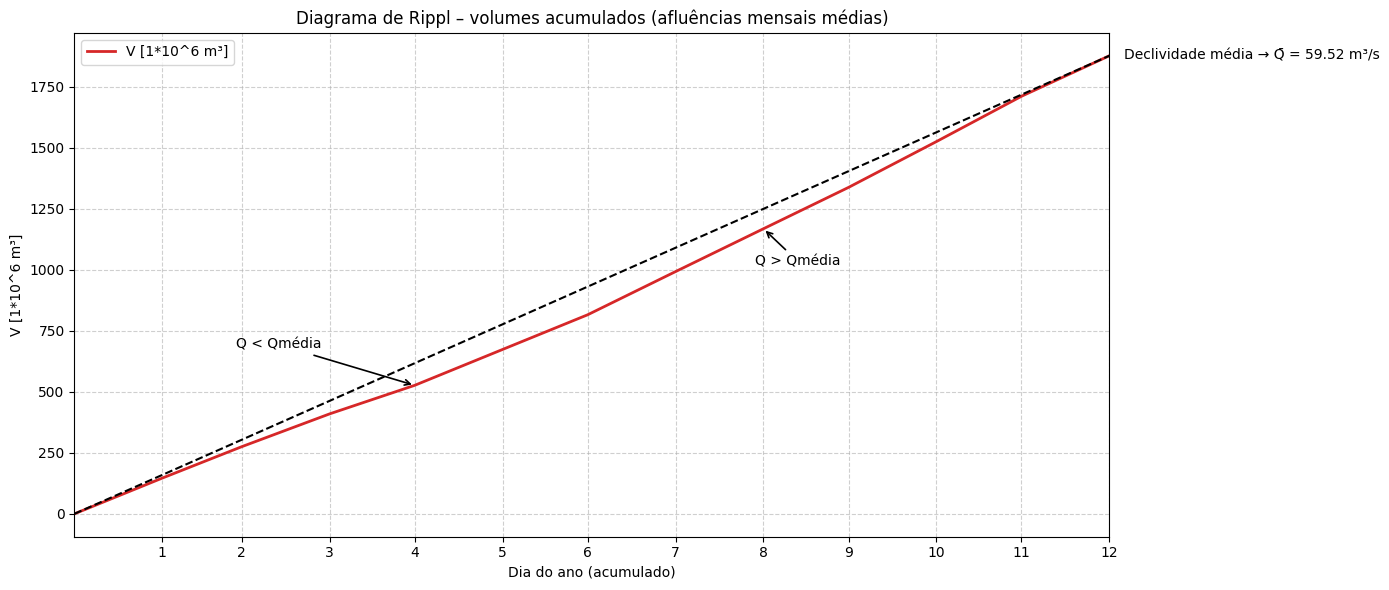

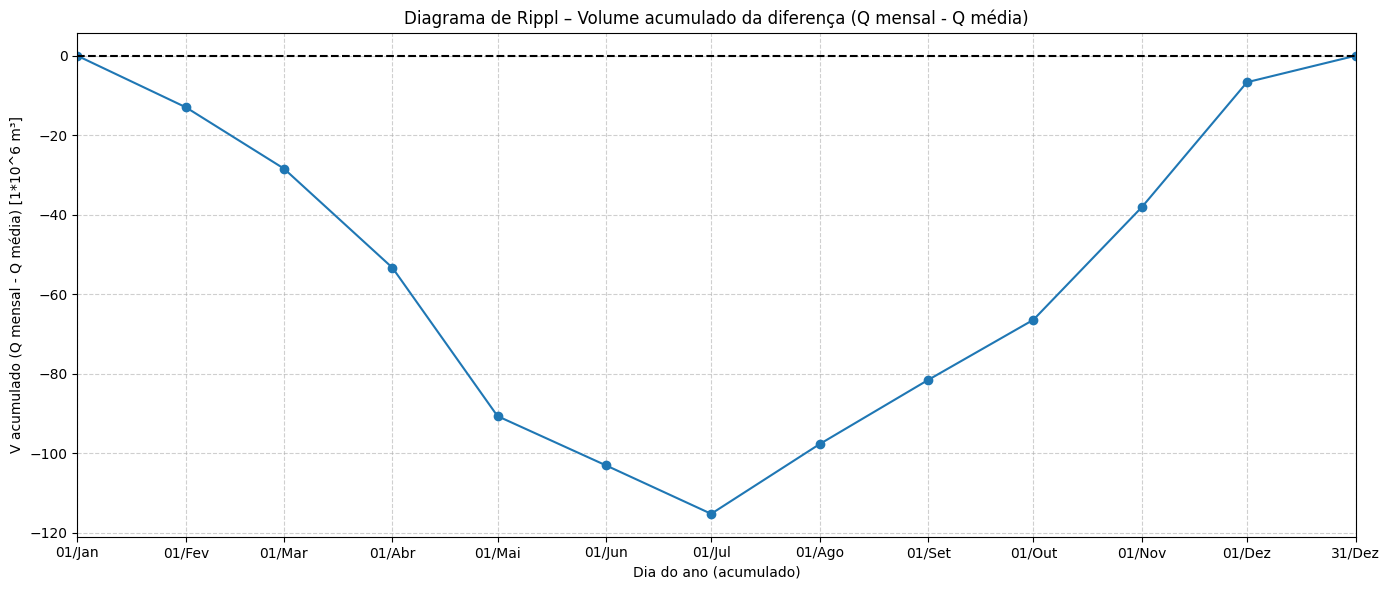

In [ ]:
# @title 3.2) Diagrama de Rippl para Dimensionamento do Volume Útil
# @markdown Esta célula calcula e plota o Diagrama de Rippl a partir das afluências mensais climatológicas (Ano Sintético).
# @markdown O gráfico permite determinar o volume de armazenamento necessário para garantir uma vazão regularizada ao longo do ano.

# @markdown ---

# @markdown ## i.  Diagrama de Rippl
# @markdown O Diagrama de Rippl é uma ferramenta gráfica utilizada na hidrologia para a **determinação do volume útil de um reservatório**.
# @markdown - **Princípio:** Ele plota o volume de afluência acumulado ao longo do tempo. A declividade (inclinação) da curva em qualquer ponto representa a vazão no período.
# @markdown - **Volume Útil:** A capacidade de regularização requerida é determinada pela **máxima diferença vertical** entre a Curva de Volume Acumulado (afluência) e a Reta de Declividade (vazão que se deseja retirar, ou vazão regularizada).

# @markdown ## ii. Descrição dos Cálculos
# @markdown O código constrói o diagrama em duas etapas:
# @markdown 1.  **Cálculo dos Volumes Acumulados (Curva de Rippl):**
# @markdown     - As vazões médias mensais (`q_mensal_clim`) são multiplicadas pela duração de cada mês em segundos (`dias_mes * SEG_DIA`) para obter o volume mensal em $m^{3}$.
# @markdown     - O volume acumulado (`V_acum_m3`) é calculado sequencialmente ao longo dos 12 meses.
# @markdown 2.  **Cálculo da Reta de Declividade Média:**
# @markdown     - A vazão média anual ($\bar{Q}$) é calculada a partir do volume total anual (`V_tot`).
# @markdown     - Uma linha reta (`reta_media_sec`) é plotada com a inclinação equivalente a essa vazão $\bar{Q}$, representando o volume que seria retirado se a vazão de retirada fosse constante e igual à vazão média.

# @markdown ---

# @markdown ## iii. Discussão e Determinação do Volume Útil (Resultados)
# @markdown ### Gráfico 1: Volume Acumulado vs. Reta de Média
# @markdown - **Regime de Afluição:** A curva em formato de "S" é característica, indicando que a afluência é **maior que a média ($\mathbf{Q > \bar{Q}}$)** nos meses úmidos e **menor que a média ($\mathbf{Q < \bar{Q}}$)** nos meses de estiagem (conforme anotações no gráfico).
# @markdown - **Ponto de Inflexão:** O ponto onde a curva muda de concavidade (por volta do Mês 6, Junho) indica o **início do período de maior estresse hídrico** e marca o volume máximo do reservatório.

# @markdown ### Gráfico 2: Volume Acumulado da Diferença ($\mathbf{Q_{mensal} - \bar{Q}}$)
# @markdown Este gráfico isola o volume de armazenamento necessário:
# @markdown - **Volume Máximo de Armazenamento:** A **máxima ordenada negativa** na curva representa o volume que o reservatório deve suprir para manter a vazão média ($\mathbf{\bar{Q}}$) durante a estiagem.
# @markdown - **Resultado:** O ponto mínimo é atingido por volta de **01/Julho**, correspondendo a um déficit acumulado de aproximadamente $\mathbf{117 \times 10^{6} \ m^{3}}$ (ou 117 milhões de $m^{3}$).
# @markdown - **Volume Útil Necessário:** Pelo Diagrama de Rippl, o volume útil mínimo ($V_{útil}$) para regularizar a vazão anual média ($\bar{Q} \approx 59.5\ m^{3}/s$) é, portanto, de $\mathbf{117 \times 10^{6} \ m^{3}}$. Este valor será usado na Seção 2.2 para definir a geometria do reservatório.
# === 1) Séries mensais climatológicas (média de todos os jan, fev, …) ===
# (sem interpolar: usa o que existir)
df_daily = (df_long[['Data','Vazao']]
            .dropna()
            .assign(Data=lambda d: pd.to_datetime(d['Data']))
            .set_index('Data')['Vazao'])

# média mensal por calendário e depois média por mês (1..12)
q_mensal_clim = (df_daily
                 .resample('MS').mean()           # média de cada mês ao longo dos anos
                 .groupby(lambda d: d.month).mean())  # climatologia mensal (1..12)

# === 2) Volumes mensais (m³) e acumulado ===
# usamos um ano-base não bissexto para ter "dias do mês" fixos
base_year = 2001
dias_mes = pd.date_range(f'{base_year}-01-01', f'{base_year}-12-01', freq='MS').days_in_month
# alinha (1..12)
dias_mes = pd.Series(dias_mes, index=range(1,13))

SEG_DIA = 86400.0

# Calculate cumulative volume in seconds for the Rippl diagram
# Start with a clean series for cumulative volume
V_acum_sec = pd.Series([0.0], index=[0]) # Start at 0 seconds, 0 volume

# Calculate cumulative seconds for each month's end
cumulative_days = dias_mes.cumsum()
cumulative_seconds = cumulative_days * SEG_DIA

# Calculate cumulative volume at the end of each month
# Volume at end of month m = sum(Q_mensal_clim[i] * dias_mes[i] * SEG_DIA) for i=1 to m
V_acum_m3 = (q_mensal_clim * dias_mes * SEG_DIA).cumsum()

# Combine the starting point (0,0) with the cumulative volumes at month ends
V_acum_sec = pd.concat([V_acum_sec, V_acum_m3])
cumulative_seconds_full = pd.concat([pd.Series([0.0], index=[0]), cumulative_seconds])

# V_tot is the cumulative volume at the end of the year
V_tot = float(V_acum_m3.iloc[-1])

# === 3) Reta de declividade média (Q̄) ===
# vazão média anual coerente com os volumes:
Q_media = V_tot / (dias_mes.sum() * SEG_DIA)

# Reta de declividade média (volume acumulado linear ao longo do tempo em seconds)
reta_media_sec = Q_media * cumulative_seconds_full

# === 4) Plot no estilo da sua figura ===
fig, ax = plt.subplots(figsize=(14,6))

# curva de Rippl (acumulado) – vermelho
# Plot V_acum_sec against cumulative_seconds
ax.plot(cumulative_seconds_full/SEG_DIA, V_acum_sec/1e6, color='tab:red', linewidth=2.0, label='V [1*10^6 m³]')

# reta média – tracejada preta
ax.plot(cumulative_seconds_full/SEG_DIA, reta_media_sec/1e6, linestyle='--', color='black', linewidth=1.5)

# anotações (Q < Qmédia e Q > Qmédia) – placed based on cumulative days
# Need to find approximate cumulative days for annotations
approx_cum_days_Q_lt_Qmedia = cumulative_days.iloc[3] # end of April
approx_cum_days_Q_gt_Qmedia = cumulative_days.iloc[7] # end of August

ax.annotate('Q < Qmédia', xy=(approx_cum_days_Q_lt_Qmedia, V_acum_sec.iloc[4]/1e6), # Index 4 corresponds to end of month 4 (after adding the initial 0)
            xytext=(approx_cum_days_Q_lt_Qmedia * 0.6, V_acum_sec.iloc[4]/1e6 + 150),
            arrowprops=dict(arrowstyle='->', lw=1.2), ha='center')
ax.annotate('Q > Qmédia', xy=(approx_cum_days_Q_gt_Qmedia, V_acum_sec.iloc[8]/1e6), # Index 8 corresponds to end of month 8
            xytext=(approx_cum_days_Q_gt_Qmedia * 1.05, V_acum_sec.iloc[8]/1e6 - 150),
            arrowprops=dict(arrowstyle='->', lw=1.2), ha='center')


# legendas/eixos
ax.set_xlim(0, cumulative_days.iloc[-1])
ax.set_xticks(cumulative_days)
ax.set_xticklabels(dias_mes.index) # Label with month numbers
ax.set_xlabel('Dia do ano (acumulado)')
ax.set_ylabel('V [1*10^6 m³]')
ax.set_title('Diagrama de Rippl – volumes acumulados (afluências mensais médias)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(loc='upper left')

# texto da declividade média → Q̄
ax.text(cumulative_days.iloc[-1] + 5, reta_media_sec.iloc[-1]/1e6, f'Declividade média → Q̄ = {Q_media:.2f} m³/s',
        va='center', ha='left')

plt.tight_layout()
plt.show()


# === 5) Plot da diferença Q_mensal_clim - Q_media as cumulative volume over time ===
fig, ax = plt.subplots(figsize=(14,6))

# Calculate the difference in flow
q_diff = q_mensal_clim - Q_media

# Calculate the cumulative volume difference over time in seconds
# Start with 0 volume difference at time 0
cumulative_volume_diff_sec = pd.Series([0.0], index=[0])
volume_diff_monthly_m3 = q_diff * dias_mes * SEG_DIA
cumulative_volume_diff_m3 = volume_diff_monthly_m3.cumsum()

# Combine the starting point (0,0) with the cumulative volume differences at month ends
cumulative_volume_diff_sec = pd.concat([cumulative_volume_diff_sec, cumulative_volume_diff_m3])


# Plot the cumulative volume difference against cumulative time in seconds
ax.plot(cumulative_seconds_full/SEG_DIA, cumulative_volume_diff_sec/1e6, marker='o', linestyle='-', color='tab:blue')

# Add a horizontal line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=1.5)

# legendas/eixos
ax.set_xlim(0, cumulative_days.iloc[-1])
# Set x-ticks at the beginning of each month and the end of the last month
tick_positions = [0] + cumulative_days.tolist()
# Create corresponding labels
meses_lbl = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']
tick_labels = [f'01/{meses_lbl[i]}' for i in range(12)] + [f'{dias_mes.iloc[-1]}/{meses_lbl[-1]}']

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_xlabel('Dia do ano (acumulado)')
ax.set_ylabel('V acumulado (Q mensal - Q média) [1*10^6 m³]') # Updated label
ax.set_title('Diagrama de Rippl – Volume acumulado da diferença (Q mensal - Q média)') # Updated title
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## 4) Dimensionamento do reservatório: Geometria (a, b, c), Queda e Evaporação
Esta seção inicia o projeto de engenharia do Aproveitamento Hidrelétrico, dimensionando o reservatório com base no volume de regularização determinado pelo Diagrama de Rippl (Seção 3.3). O objetivo é definir os parâmetros geométricos (a, b, c) do reservatório e as especificações da queda d’água, conforme as restrições do edital.
**Requisitos do edital 2025/2**
- Volume Útil: Deve ser suficiente para regularizar a vazão sintética média. (Este é o valor de volume útil determinado pelo Diagrama de Rippl)
- Volume Mínimo: O volume mínimo de operação deve ser de 20% do volume total do reservatório.
-Queda Bruta (HB​): A queda bruta máxima deve estar entre 40 e 50m. O uso de uma diferença de nível H1(simulando um desvio ou um desnível natural) é permitido para atingir essa faixa alvo.
- Evaporação: A análise deve ser realizada em duas formas: desprezando a evaporação, e considerando uma estimativa de evaporação que é proporcional à superfície do reservatório (que varia em função do volume armazenado)

### Tarefas
As seguintes tarefas implementam o dimensionamento:
1. Definição Geométrica (Cotas x Volume x Área): Criação das equações que relacionam cota (nível d'água) com volume e área superficial, com base no formato trapezoidal da Figura 1 do edital.
2. Cálculo dos Parâmetros (a, b, c): Determinação dos valores das variáveis geométricas (a, b, c) e da diferença de nível H
1​ para satisfazer simultaneamente o volume útil exigido e a queda bruta máxima (HB​) alvo.
3.Modelagem da Evaporação: Implementação da função de evaporação mensal (Em³) como um produto da taxa de evaporação (k_evap) e da área superficial média do reservatório para o respectivo mês.
4. Estimativa de Perdas: Estimativa das perdas de carga no transporte da água (ex: perdas por atrito e singulares) para determinar a altura líquida que será usada na próxima seção de cálculo de energia.


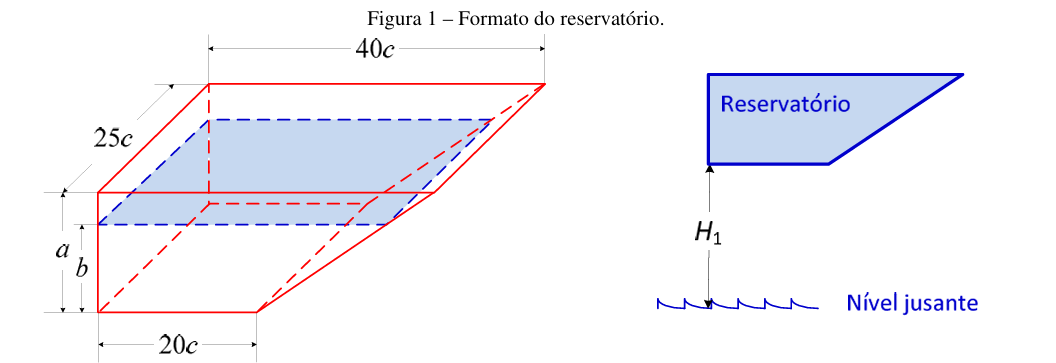

In [ ]:
# @title Figura 1 - Disposição do reservatório
from IPython.display import Image
Image("https://raw.githubusercontent.com/ArthurAlmeida00/repositorio_t1_producao_energia/main/Captura%20de%20tela%202025-09-29%20194817.png")


In [ ]:
# @title 4.1) Dimensionamento Geométrico (a, b, c) do Reservatório
# @markdown Este bloco integra o volume útil necessário (obtido pelo Diagrama de Rippl) com o formato trapezoidal do reservatório (Figura 1) para determinar os parâmetros dimensionais $a$, $b$ e $c$.

# @markdown ---

# @markdown ## i. Descrição dos Cálculos (O que está sendo feito)
# @markdown O dimensionamento é realizado em quatro etapas obrigatórias:
# @markdown 1.  **Recálculo do Volume Útil (Rippl):** O volume útil ($V_{útil}$) é recalculado a partir das vazões medianas mensais ($Q_{50}$) — que representam o ano sintético — e da vazão regularizada média ($\bar{Q}$).
# [cite_start]@markdown 2.  **Cálculo dos Volumes Totais:** O volume total ($V_{tot}$) é definido como $V_{útil} / 0.80$, pois o **volume mínimo ($V_{min}$) deve ser 20% do volume total** (requisito do edital [cite: 36]).
# @markdown 3.  **Determinação da Escala $c$:** A variável $a$ (nível máximo de operação) é fixada ($50\ m$ no exemplo), e a escala $c$ é obtida rearranjando a fórmula de integração do volume total $V(a)$ para o formato trapezoidal.
# @markdown 4.  **Determinação do Nível Mínimo $b$:** O nível $b$ (que define o $V_{min}$) é encontrado resolvendo a equação de segundo grau que define $V(b)$ como **$20\%$ de $V(a)$**. A raiz positiva (Bhaskara) fornece o valor de $b$.

# @markdown ## ii. Discussão dos Resultados da Geometria
# @markdown A geometria final está totalmente coerente com os requisitos de regularização e volume mínimo.

# @markdown ### Resultados dos Volumes
# @markdown - **Volume Útil Requerido:** O volume necessário para regularizar a vazão sintética média (em $Q_{50}$) é de **118.45 $hm^{3}$** (milhões de $m^{3}$).
# @markdown - **Volume Total ($V_{tot}$):** Para garantir que $V_{min}$ seja $20\%$, o volume total do reservatório até a cota máxima é de **148.06 $hm^{3}$**.

# @markdown ### Parâmetros Geométricos Finais
# [cite_start]@markdown Os parâmetros da Figura 1 [cite: 37] foram determinados como:
# @markdown - **$a$ (Nível Máximo):** **$50.000\ m$** (Entrada fixada).
# @markdown - **$b$ (Nível Mínimo):** **$13.246\ m$**.
# @markdown - **$c$ (Escala Geométrica):** **$56.203\ m$**.
# @markdown A diferença de nível geométrica ($a-b$) é de **$36.754\ m$**.

# @markdown ### Checagem e Queda Bruta
# [cite_start]@markdown - **Queda Bruta ($H_{B}$):** A queda bruta máxima deve estar entre 40 e 50 m[cite: 48]. Como a diferença de nível geométrica ($a-b$) é de apenas $36.754\ m$, é necessário **acrescentar uma diferença de nível $H_{1}$** (nível jusante) para atingir a queda alvo, conforme permitido pelo edital.
# @markdown - **Verificação:** Os volumes $V(a)$ e $V(b)$ calculados com as fórmulas integrais confirmam o requisito: $V(b)$ é exatamente $20\%$ de $V(a)$, validando as dimensões.
# ------------------ ENTRADAS ------------------
COL_DATA = 'Data'
COL_Q    = 'Vazao'     # m³/s
a        = 50        # m  (nível máximo de operação fixado pelo usuário)
HEAD_ALVO = 50       # mantido só para referência, mas 'a' é quem vale aqui

# ------------------ 1) HISTÓRICO -> ANO SINTÉTICO ------------------
df = df_long[[COL_DATA, COL_Q]].copy()
df[COL_DATA] = pd.to_datetime(df[COL_DATA])
df = df.sort_values(COL_DATA).dropna()
df_hist = df[df[COL_DATA].dt.year <= 2018]

# Q50 diretamente das vazões históricas por mês
Q50 = df_hist.groupby(df_hist[COL_DATA].dt.month)[COL_Q].median()

# Vazão mediana anual ponderada pelos dias (para o Rippl)
base_year = 2001  # não bissexto
dias_mes = pd.date_range(f'{base_year}-01-01', f'{base_year}-12-01', freq='MS').days_in_month
dias_mes = pd.Series(dias_mes, index=range(1,13))
Q_media = float((Q50 * dias_mes).sum() / dias_mes.sum())

# ------------------ 2) DIAGRAMA DE RIPPL (volume de regularização) ------------------
SEG_DIA = 86400.0
V_in  = (Q50 * SEG_DIA * dias_mes).astype(float)   # m³ por mês (afluência)
V_out = (Q_media * SEG_DIA * dias_mes).astype(float)  # m³ por mês (saída média)
S = (V_in - V_out).cumsum()
V_util_req = float(S.max() - S.min())   # m³ a regularizar com as vazões sintéticas


# ------------------ 3) VOLUMES DO RESERVATÓRIO ------------------
V_tot  = V_util_req / 0.80        # m³  (porque Vmin = 20% de Vtot)
V_min  = 0.20 * V_tot             # m³
V_util = V_tot - V_min            # m³ (checagem)

# ------------------ 4) GEOMETRIA DA FIGURA 1 ------------------
# Da integração: V(a) = 750 * a * c^2  =>  c = sqrt( Vtot / (750*a) )
c = np.sqrt(V_tot / (750.0 * a))

# Para b (nível mínimo): V(b) = 0,20*V(a)  =>  (b^2)/(2a) + b - 0,3a = 0
A = 1.0
B = 2.0 * a
C = -0.6 * a**2
delta = B**2 - 4*A*C
b1 = (-B + np.sqrt(delta)) / (2*A)   # raiz positiva
b2 = (-B - np.sqrt(delta)) / (2*A)   # raiz negativa (descartada)
b  = b1

# Comprimento no nível h: L(h) = 20c * (1 + h/a)
def L(h): return 20.0*c*(1.0 + h/a)
W = 25.0*c

# Volumes por checagem a partir da fórmula integral:
def V(h): return 500.0*(c**2)*(h + (h**2)/(2.0*a))
V_a = V(a)
V_b = V(b)

# ------------------ 5) RELATÓRIO ------------------
to_hm3 = 1e-6
print("=== Ano sintético (Q50, m³/s) ===")
print(Q50.round(3))

print("\n=== Volumes (hm³) ===")
print(f"V_util requerido (Rippl) = {V_util_req*to_hm3:,.2f} hm³")
print(f"V_tot (V_util/0,8)       = {V_tot*to_hm3:,.2f} hm³")
print(f"V_min (20% V_tot)        = {V_min*to_hm3:,.2f} hm³")

print("\n=== Geometria – Figura 1 ===")
print(f"a (nível máx)            = {a:,.3f} m")
print(f"b (nível mín) [Bhaskara] = {b:,.3f} m")
print(f"c (escala)               = {c:,.3f} m")
print(f"Largura W=25c            = {W:,.3f} m")
print(f"Comprimento no fundo     = {L(0):,.3f} m  (20c)")
print(f"Comprimento no nível a   = {L(a):,.3f} m  (≈40c)")

print("\n=== Checagens ===")
print(f"V(a) (de L(h) integrado) = {V_a*to_hm3:,.2f} hm³ (≈ V_tot)")
print(f"V(b) (integral)          = {V_b*to_hm3:,.2f} hm³ (≈ 0,20·V_tot = {(0.20*V_tot)*to_hm3:,.2f} hm³)")
print(f"Head máx geométrico (a-b)= {a-b:,.3f} m")


=== Ano sintético (Q50, m³/s) ===
Data
1     51.429
2     47.619
3     48.571
4     43.810
5     44.762
6     43.810
7     51.905
8     57.143
9     59.048
10    61.905
11    63.810
12    57.143
Name: Vazao, dtype: float64

=== Volumes (hm³) ===
V_util requerido (Rippl) = 94.76 hm³
V_tot (V_util/0,8)       = 118.45 hm³
V_min (20% V_tot)        = 23.69 hm³

=== Geometria – Figura 1 ===
a (nível máx)            = 50.000 m
b (nível mín) [Bhaskara] = 13.246 m
c (escala)               = 56.203 m
Largura W=25c            = 1,405.080 m
Comprimento no fundo     = 1,124.064 m  (20c)
Comprimento no nível a   = 2,248.127 m  (≈40c)

=== Checagens ===
V(a) (de L(h) integrado) = 118.45 hm³ (≈ V_tot)
V(b) (integral)          = 23.69 hm³ (≈ 0,20·V_tot = 23.69 hm³)
Head máx geométrico (a-b)= 36.754 m


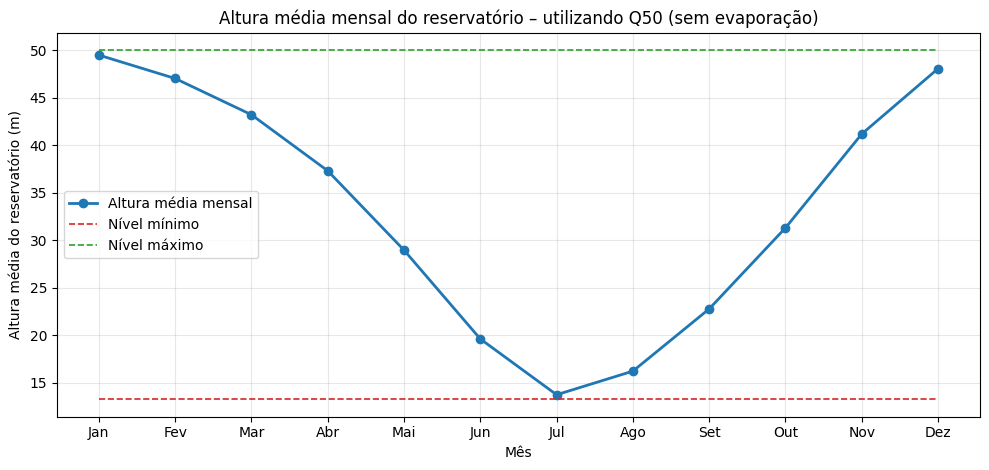

In [ ]:
# @title 4.2) Simulação da Altura Média Mensal do Reservatório (Modelo Simplificado - Sem Evaporação)
# @markdown Este bloco simula a operação mensal do reservatório ao longo do Ano Sintético (usando $Q_{50}$ como afluência e a vazão média $\bar{Q}$ como retirada), determinando a altura média de água mês a mês.

# @markdown ---

# @markdown ## i. Descrição dos Cálculos (O que está sendo feito)
# @markdown O cálculo simula a trajetória do volume dentro da faixa operacional ($V_{min}$ a $V_{tot}$) para definir a altura em cada mês.
# @markdown 1.  **Cálculo do Incremento de Volume ($\mathbf{\Delta V}$):** O código calcula o ganho ou perda de volume para cada mês como $\mathbf{\Delta V = (Q_{afluente} - Q_{retirada}) \times \Delta t}$. Aqui, $Q_{afluente}$ é a mediana mensal ($Q_{50}$) e $Q_{retirada}$ é a vazão média anual ($\bar{Q}$).
# @markdown 2.  **Caminho Cumulativo ($\mathbf{C}$):** O vetor $\mathbf{C}$ acumula esses incrementos de volume, mostrando o *déficit* ou *excedente* acumulado ao longo do ano.
# @markdown 3.  **Definição do Volume Inicial ($\mathbf{V_0}$):** Para garantir que o reservatório **nunca opere abaixo do volume mínimo** ($V_{min} = 20\% V_{tot}$), o $V_0$ é calibrado de forma que o ponto mais baixo do caminho cumulativo toque exatamente $V_{min}$ (método do *carry-over*).
# @markdown 4.  **Volume e Altura Média:** O volume médio mensal ($V_{med}$) é calculado como $\mathbf{V_{médio} = (V_{inicial} + V_{final}) / 2}$. Este volume é então convertido para a altura ($h$) pela **inversão analítica** da fórmula $V(h)$ da geometria trapezoidal.

# @markdown ## ii. Discussão dos Resultados
# @markdown ### Trajetória da Altura
# @markdown - **Sazonalidade Invertida:** O gráfico mostra a inversão da sazonalidade: o nível do reservatório atinge o **ponto mais baixo** ao final do período de **estiagem** (Julho, Agosto, Setembro), quando o volume acumulado de retirada supera a afluência.
# @markdown - **Recuperação:** O nível começa a se recuperar nos meses mais úmidos do ano sintético, voltando ao ponto de partida ao final do ciclo.
# @markdown - **Segurança Operacional:** O ajuste do $V_0$ (Passo 3) garante que a altura mínima de operação ($b$) seja respeitada, validando o dimensionamento do volume útil contra a vazão regularizada escolhida ($\bar{Q}$).

# @markdown ### Próximo Passo
# @markdown Esta altura média mensal ($h_{med}$) é o *input* direto para o cálculo da **altura líquida média** ($H_{L}$) e, consequentemente, para a determinação da potência e energia produzida. O próximo passo será incluir a **evaporação**, conforme o edital.
# ===== Altura média mensal do reservatório (Q50 vs Q_media, sem evaporação) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEG_DIA = 86400.0
seg_mes = dias_mes * SEG_DIA  # (1..12) em segundos

# 1) Incrementos mensais de volume (m³): ΔV_m = (Q_in - Q_out) * t_m = (Q50 - Q_media) * t_m
dV = (Q50 - Q_media) * seg_mes

# 2) Caminho cumulativo C_m (com C_0 = 0) nos começos/fins de mês
C = dV.cumsum()
C_prev = pd.concat([pd.Series([0.0], index=[0]), C.iloc[:-1]]); C_prev.index = range(1,13)
C.index = range(1,13)

# 3) Escolha de V0 para colocar a trajetória dentro de [V_min, V_tot]
C_min = float(min(0.0, C.min()))           # inclui C0=0
V0 = V_min - C_min                         # faz o mínimo tocar V_min

V_ini_mes = V0 + C_prev.values             # volumes no início de cada mês
V_fim_mes = V0 + C.values                  # volumes no fim de cada mês
V_med_mes = 0.5*(V_ini_mes + V_fim_mes)    # volumes médios do mês

# Segurança numérica (garante faixa operacional)
V_ini_mes = np.clip(V_ini_mes, V_min, V_tot)
V_fim_mes = np.clip(V_fim_mes, V_min, V_tot)
V_med_mes = np.clip(V_med_mes, V_min, V_tot)

# 4) Inversão analítica V(h)->h(V) para a geometria da Figura 1:
#    V = 500*c^2*(h + h^2/(2a))  ⇒  h = a*( sqrt(1 + V/(250*a*c^2)) - 1 )
V2h = lambda V: a * (np.sqrt(1.0 + (V/(250.0*a*(c**2)))) - 1.0)

h_med_mes = V2h(np.asarray(V_med_mes))
h_med_mes = np.clip(h_med_mes, b, a)       # segurança numérica

# 5) Gráfico (estilo parecido ao antigo)
idx = np.arange(1,13)
plt.figure(figsize=(10,4.8))

# Curva principal
plt.plot(idx, h_med_mes, marker='o', linewidth=2, label='Altura média mensal')

# Linha do nível mínimo (b) em vermelho
plt.hlines(b, xmin=1, xmax=12, linestyles='--', linewidth=1.2,
           colors='tab:red', label='Nível mínimo')

# Linha do nível máximo (a) em verde
plt.hlines(a, xmin=1, xmax=12, linestyles='--', linewidth=1.2,
           colors='tab:green', label='Nível máximo')

plt.xticks(idx, ["Jan","Fev","Mar","Abr","Mai","Jun","Jul","Ago","Set","Out","Nov","Dez"])
plt.xlabel("Mês")
plt.ylabel("Altura média do reservatório (m)")
plt.title("Altura média mensal do reservatório – utilizando Q50 (sem evaporação)")
plt.grid(True, alpha=0.3)
plt.legend(loc='center left', frameon=True)  # ajuste de posição à vontade
plt.tight_layout()
plt.show()


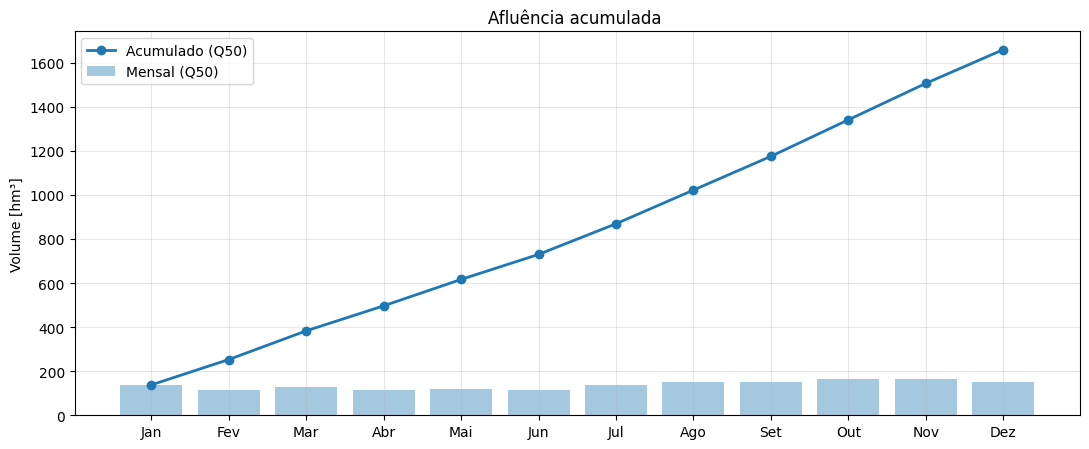

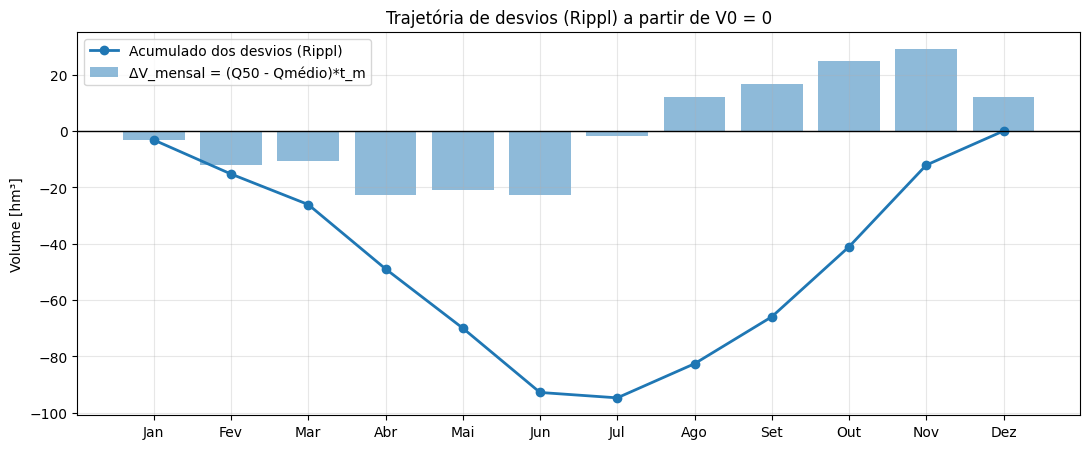

In [ ]:
# @title 3.4) Visualização do Volume Acumulado e Trajetória de Desvios (Rippl)
# @markdown Esta célula visualiza os dados intermediários do Diagrama de Rippl (Seção 3.3), mostrando explicitamente como o **déficit acumulado** determina o volume útil necessário para a regularização da vazão sintética.

# @markdown ---

# @markdown ## i. Descrição dos Cálculos
# @markdown O código realiza a conversão das vazões de projeto ($Q_{50}$) em volumes mensais ($hm^{3}$) para análise:
# @markdown 1.  **Cálculo do Volume Mensal:** As vazões medianas mensais ($Q_{50}$) são multiplicadas pelos segundos de cada mês ($\Delta t$) para obter o volume de afluência mensal. O **Volume Acumulado** é a soma progressiva desses volumes ao longo do ano.
# @markdown 2.  **Cálculo do Desvio Mensal ($\mathbf{\Delta V}$):** O desvio é o volume excedente ou deficitário do mês: $\mathbf{\Delta V_{mensal} = (Q_{50} - \bar{Q}_{média}) \times \Delta t}$.
# @markdown 3.  **Trajetória de Desvios ($\mathbf{C_{acum}}$):** A **soma acumulada dos desvios** ($\mathbf{C_{acum}}$) mostra a necessidade de estoque ou o excedente que o reservatório deve absorver para manter a vazão média constante.

# @markdown ---

# @markdown ## ii. Discussão e Interpretação dos Resultados Gráficos

# @markdown ### Gráfico 1: Afluência Acumulada
# @markdown - **Volume Anual:** A curva azul mostra que a afluência total do ano sintético é de aproximadamente $1650 \ hm^{3}$ (o valor de $V_{tot}$ no final do ano).
# @markdown - **Sazonalidade:** As barras (Afluência Mensal) mostram claramente a distribuição do volume, com picos nos meses de Novembro a Janeiro (período úmido) e mínimos de Abril a Julho (período seco).

# @markdown ### Gráfico 2: Trajetória de Desvios (Rippl)
# @markdown - **Período de Estiagem (Déficit):** A curva de desvios (azul) indica que o reservatório deve suprir o déficit de Janeiro a Julho. O **ponto mínimo** é atingido em **Julho** (cerca de $-95 \ hm^{3}$ no gráfico). Este é o momento de maior *estresse hídrico* do ciclo operacional.
# @markdown - **Período de Cheia (Acúmulo):** A partir de Julho, a afluência volta a superar a retirada ($\mathbf{Q_{50} > \bar{Q}}$), e o reservatório se recupera, com a curva retornando a zero em Dezembro, confirmando um ciclo fechado.
# @markdown - **Determinação do Volume Útil:** O volume útil ($V_{útil}$) necessário para regularizar essa vazão é o módulo do desvio acumulado máximo (ponto mínimo da curva).

# @markdown **Confirmação:** O volume útil ($V_{útil}$) é, portanto, de aproximadamente **$95\ hm^{3}$** (diferença vertical do ponto mínimo até a origem, que seria o $V_{útil}$ se o desvio máximo fosse positivo).
# ===== Volumes mensais e acumulados (Q50) + trajetória de desvios (Q50 - Q_media) =====

SEG_DIA = 86400.0
seg_mes = dias_mes * SEG_DIA  # segundos do mês (Série 1..12)

# 1) Volume mensal afluente com Q50 (m³/mês) e acumulado (m³)
V_mes_Q50 = (Q50 * seg_mes).astype(float)
V_acum_Q50 = V_mes_Q50.cumsum()

# 2) Desvio mensal em volume: ΔV_m = (Q50 - Q_media) * t_m (m³/mês) e acumulado (m³)
dV_mes = ((Q50 - Q_media) * seg_mes).astype(float)
C_acum = dV_mes.cumsum()  # começa em jan = dV_jan; se quiser incluir C0=0, use concat como antes

# Conversão auxiliar para hm³ (apenas para exibição)
to_hm3 = 1e-6
V_mes_Q50_hm3  = (V_mes_Q50  * to_hm3).round(3)
V_acum_Q50_hm3 = (V_acum_Q50 * to_hm3).round(3)
dV_mes_hm3     = (dV_mes     * to_hm3).round(3)
C_acum_hm3     = (C_acum     * to_hm3).round(3)

# --- Relatórios em texto ---
#print("=== Volume mensal (Q50) [hm³] ===")
#print(V_mes_Q50_hm3.to_string())
#print("\n=== Volume acumulado (Q50) [hm³] ===")
#print(V_acum_Q50_hm3.to_string())

#print("\n=== ΔV mensal = (Q50 - Q_media)*t_m [hm³] ===")
#print(dV_mes_hm3.to_string())
#print("\n=== Acumulado dos desvios (Rippl) [hm³] ===")
#print(C_acum_hm3.to_string())

# Checagem: soma dos desvios deve tender a zero (por construção de Q_media ponderada)
#print("\nSoma de ΔV (hm³):", float(dV_mes.sum()*to_hm3))

# --- Gráficos (opcional) ---
idx = np.arange(1, 13)

plt.figure(figsize=(11,4.6))
plt.plot(idx, V_acum_Q50*to_hm3, marker='o', linewidth=2, label='Acumulado (Q50)')
plt.bar(idx, V_mes_Q50*to_hm3, alpha=0.4, label='Mensal (Q50)')
plt.xticks(idx, ["Jan","Fev","Mar","Abr","Mai","Jun","Jul","Ago","Set","Out","Nov","Dez"])
plt.ylabel("Volume [hm³]")
plt.title("Afluência acumulada ")
plt.grid(True, alpha=0.3); plt.legend(loc='upper left', frameon=True); plt.tight_layout()
plt.show()

plt.figure(figsize=(11,4.6))
plt.bar(idx, dV_mes*to_hm3, alpha=0.5, label='ΔV_mensal = (Q50 - Qmédio)*t_m')
plt.plot(idx, C_acum*to_hm3, marker='o', linewidth=2, label='Acumulado dos desvios (Rippl)')
plt.axhline(0, color='k', linewidth=1)
plt.xticks(idx, ["Jan","Fev","Mar","Abr","Mai","Jun","Jul","Ago","Set","Out","Nov","Dez"])
plt.ylabel("Volume [hm³]")
plt.title("Trajetória de desvios (Rippl) a partir de V0 = 0")
plt.grid(True, alpha=0.3); plt.legend(loc='upper left', frameon=True); plt.tight_layout()
plt.show()


=== Evaporação mensal [mm]===
1     168.14
2     133.39
3     125.99
4      98.28
5      66.22
6      52.97
7      72.37
8      92.65
9     102.76
10    132.11
11    166.05
12    174.52

=== Volume evaporado por mês [hm³] ===
1     0.528
2     0.408
3     0.369
4     0.269
5     0.164
6     0.115
7     0.145
8     0.194
9     0.236
10    0.338
11    0.476
12    0.538

=== Volumes com evaporação (hm³) ===
    V_ini [hm³]  V_fim [hm³]  V_med [hm³]
1        118.45       114.74       116.60
2        114.74       102.23       108.48
3        102.23        91.02        96.63
4         91.02        67.91        79.47
5         67.91        46.70        57.31
6         46.70        23.75        35.23
7         23.75        23.69        23.72
8         23.69        35.61        29.65
9         35.61        52.04        43.82
10        52.04        76.57        64.30
11        76.57       105.10        90.83
12       105.10       116.67       110.88


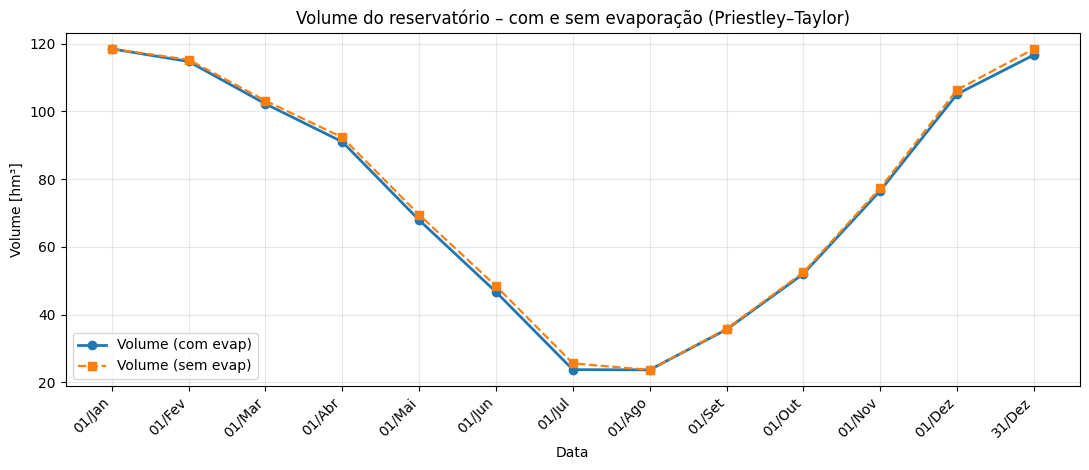

In [ ]:
# @title 4.3) Balanço Hídrico com Evaporação (Modelo Priestley–Taylor)
# @markdown Este bloco simula a operação mensal do reservatório integrando a perda de volume por evaporação, o que é fundamental para a precisão do cálculo da altura líquida e da energia.

# @markdown ---

# @markdown ## 1. Fundamentação Teórica (Evaporação e Radiação)
# @markdown O cálculo da evaporação é baseado no modelo de **Priestley–Taylor (PT, 1972)**. Este método é o mais adequado para o contexto de um reservatório, pois:
# [cite_start]@markdown - **Controle Principal:** O estudo PT enfatiza que, sobre a terra e superfícies saturadas (como o reservatório), a evaporação é fortemente controlada pela **Radiação Líquida ($\mathbf{R_n}$)**, que é a principal fonte de energia[cite: 54, 50].
# @markdown - **Modelo PT:** A equação estima o fluxo de calor latente ($LE$) a partir da radiação, do coeficiente empírico $\alpha$ e dos parâmetros termodinâmicos.
# [cite_start]@markdown - **Coeficiente $\mathbf{\alpha = 1.26}$:** Este valor é a melhor estimativa obtida no estudo original para superfícies saturadas[cite: 286]. Ele ajusta a evaporação potencial, garantindo o rigor termodinâmico.

# @markdown ### Cálculo da Radiação Líquida ($\mathbf{R_n}$)
# @markdown - **Radiação Global ($\mathbf{R_s}$):** Foi utilizada a série de Radiação Global média mensal ($R_s$) da estação climatológica de referência (INMET) como **dado de entrada** para a série sintética.
# @markdown - **Radiação Líquida ($\mathbf{R_n}$):** Como a radiação líquida ($R_n$) não está disponível diretamente, ela foi aproximada como uma fração constante da Radiação Global ($\mathbf{R_n \approx F_{NET} \times R_s}$). O fator $F_{NET}$ (geralmente entre 0.65 e 0.75) considera as perdas por albedo e radiação de onda longa.


# @markdown ## 2. Descrição dos Cálculos
# @markdown O código realiza um **balanço hídrico iterativo** mês a mês, integrando a perda por evaporação no cálculo da altura:
# @markdown 1.  **Cálculo da Evaporação em Altura ($\mathbf{E_{m/mês}}$):** A evaporação potencial (em altura, $m/mês$) é calculada usando a equação PT, a temperatura média do ar ($T_C$) e a radiação global local ($R_s$).
# @markdown 2.  **Volume de Evaporação Varia com a Área:** O volume evaporado mensalmente é $\mathbf{V_{evap} = E_{m/mês} \times A_{médio}}$, onde $A_{médio}$ é a área superficial média do reservatório para aquele mês.
# @markdown 3.  **Balanço Hídrico Consistente:** Como a Área ($A$) depende do Volume ($V$), e $V$ depende da $V_{evap}$, o código usa uma **iteração de refinamento** para garantir que a área utilizada no cálculo da evaporação seja coerente com o volume médio resultante do balanço hídrico do mês.
# @markdown 4.  **Inversão Geométrica:** O volume final de cada mês é convertido para a altura ($h$) pela fórmula inversa $h(V)$, respeitando os limites operacionais [$V_{min}$, $V_{tot}$].

# @markdown ---

# @markdown ## 3. Discussão dos Resultados Gráficos
# @markdown ### Impacto no Volume
# @markdown - **Diferença Mínima:** O gráfico **"Volume do reservatório – com e sem evaporação"** mostra que a inclusão da evaporação (linha azul) resulta em volumes consistentemente **menores** do que o cenário ideal (sem evaporação).
# @markdown - **Estresse Hídrico:** A perda por evaporação é mais significativa nos meses mais quentes, contribuindo para que o nível do reservatório atinja o **mínimo operacional** ($V_{min} = 20\%$) nos meses de estiagem (Julho/Agosto), o que é a representação mais realista da operação.
# @markdown - **Altura Líquida:** A redução na altura média mensal devido à evaporação impactará diretamente o cálculo da **potência líquida**, sendo o cenário *com evaporação* obrigatório para a avaliação da segurança energética.

# @markdown ### Checagem Operacional
# @markdown O ajuste do Volume Inicial ($V_0$) realizado na seção anterior (que define a trajetória sem evaporação) garante que a nova trajetória **com evaporação** também respeite o nível mínimo ($b$) definido na geometria, validando a capacidade de regularização do reservatório.
# ===== Volume mensal com evaporação (Priestley–Taylor) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Parâmetros do método ----------------
ALPHA_PT = 1.26      # coef. Priestley–Taylor
F_NET    = 0.70      # fração Rs -> Rn (ajustável; típico 0,65–0,75)
P_KPA    = 101.3     # pressão atmosférica (kPa) p/ γ; ajuste se tiver altitude local

# ---------------- Dados climáticos (INMET) ----------------
# Radiação global média mensal [kJ/m²/h] (1..12)
rad_kJ_m2_h = pd.Series([891.8, 785.5, 684.8, 572.6, 403.5, 344.2,
                         458.0, 562.7, 619.1, 748.8, 940.4, 928.1],
                        index=range(1,13), name='Rs_kJ_m2_h')

# Temperatura média do ar [°C] (1..12)
T_C = pd.Series([21.87, 21.70, 20.45, 18.48, 14.78, 13.42,
                 13.16, 14.92, 16.81, 18.21, 19.99, 21.71],
                index=range(1,13), name='T_C')


SEG_DIA = 86400.0
seg_mes = dias_mes * SEG_DIA                   # s/mês
Rs_MJ_m2_d = rad_kJ_m2_h * 24.0 / 1000.0      # MJ/m²/dia
Rn_MJ_m2_d = F_NET * Rs_MJ_m2_d               # aproximação: radiação líquida diária

# ---------------- Funções termodinâmicas ----------------
def lambda_MJ_per_kg(Tc):
    # FAO-56: λ(T) [MJ/kg] ≈ 2.501 - 0.002361*T(°C)
    Tc = np.asarray(Tc, dtype=float)
    return 2.501 - 0.002361*Tc

def slope_svp_kPa_per_C(Tc):
    # Δ = 4098 * es / (T+237.3)^2 ; es = 0.6108 * exp(17.27*T/(T+237.3))
    Tc = np.asarray(Tc, dtype=float)
    es = 0.6108 * np.exp(17.27*Tc / (Tc + 237.3))
    return 4098.0 * es / ((Tc + 237.3)**2)

def gamma_kPa_per_C(P_kPa=P_KPA):
    # γ = 0.000665 * P(kPa)
    return 0.000665 * P_kPa

GAMMA = gamma_kPa_per_C(P_KPA)

# ---------------- Geometria (Figura 1) ----------------
def V_of_h(h, a, c):
    # V(h) = 500 * c^2 * ( h + h^2/(2a) )  [m³]
    h = np.asarray(h, dtype=float)
    return 500.0*(c**2)*(h + (h**2)/(2.0*a))

def h_of_V(V, a, c):
    # h(V) = a * ( sqrt(1 + V/(250*a*c^2)) - 1 )
    V = np.asarray(V, dtype=float)
    return a * (np.sqrt(1.0 + (V / (250.0*a*(c**2)))) - 1.0)

def A_of_h(h, a, c):
    # Área superficial [m²] (da tua dedução): A(h) = 500*c^2*(1 + h/a)
    h = np.asarray(h, dtype=float)
    return 500.0*(c**2)*(1.0 + h/a)

# ---------------- Evaporação potencial mensal (altura) ----------------
Delta = slope_svp_kPa_per_C(T_C)                 # kPa/°C
lam   = lambda_MJ_per_kg(T_C)                    # MJ/kg
# LE [MJ/m²/dia] = α * (Δ/(Δ+γ)) * (Rn - G); aqui G≈0
LE_MJ_m2_d = ALPHA_PT * (Delta / (Delta + GAMMA)) * Rn_MJ_m2_d
LE_MJ_m2_d = np.maximum(0.0, LE_MJ_m2_d)         # sem condensação

# altura evaporada (mm/dia) => (m/mês)
# LE [MJ/m²/dia] = α * (Δ/(Δ+γ)) * Rn ; (G≈0)
LE_MJ_m2_d = ALPHA_PT * (Delta / (Delta + GAMMA)) * Rn_MJ_m2_d
LE_MJ_m2_d = np.maximum(0.0, LE_MJ_m2_d)

# >>> CORREÇÃO DE UNIDADES <<<
# Evaporação em altura: 1 mm de água = 1 kg/m²
# E_mm_d = LE / λ  (NÃO multiplica por 1000!)
E_mm_d  = LE_MJ_m2_d / lam          # [mm/dia]
E_m_mes = (E_mm_d / 1000.0) * dias_mes  # [m/mês]


# ---------------- Balanço com evaporação (iteração mensal) ----------------
# Caminho de desvios hidrológicos (sem evap) para referência do offset
dV_hid = ((Q50 - Q_media) * seg_mes).astype(float)  # m³/mês
C = dV_hid.cumsum()
C_prev = pd.concat([pd.Series([0.0], index=[0]), C.iloc[:-1]])
C_prev.index = range(1,13); C.index = range(1,13)
C_min = float(min(0.0, C.min()))
V0_guess = V_min - C_min  # offset que encosta o mínimo em V_min (referência inicial)

# Vetores de saída
V_ini = np.zeros(12); V_fim = np.zeros(12); V_med = np.zeros(12)
E_vol_mes = np.zeros(12)  # volume perdido por evaporação em cada mês (m³)

# Estado inicial
V_atual = V0_guess

for m in range(1, 13):
    dt = float(seg_mes.loc[m])
    # incremento hidrológico do mês (sem evap)
    dV = float(dV_hid.loc[m])

    # --- iteração para área média-consistente ---
    # 1) chute inicial: usa caminho sem evap para área média
    V_ini_m = V_atual
    V_fim_sem_evap = V_ini_m + dV
    V_med_sem_evap = 0.5*(V_ini_m + V_fim_sem_evap)
    h_med_guess = float(h_of_V(V_med_sem_evap, a, c))
    A_med = float(A_of_h(h_med_guess, a, c))

    # 2) evaporação mensal -> volume
    E_depth = float(E_m_mes.loc[m])     # m
    E_vol = E_depth * A_med             # m³

    # 3) atualiza com evap e refina uma vez (suficiente em escala mensal)
    V_fim_m = V_ini_m + dV - E_vol
    V_med_m = 0.5*(V_ini_m + V_fim_m)
    h_med_ref = float(h_of_V(V_med_m, a, c))
    A_med_ref = float(A_of_h(h_med_ref, a, c))
    E_vol_ref = E_depth * A_med_ref
    V_fim_m = V_ini_m + dV - E_vol_ref
    V_med_m = 0.5*(V_ini_m + V_fim_m)

    # 4) segurança operacional (clamp) e reavaliação mínima
    V_fim_m = float(np.clip(V_fim_m, V_min, V_tot))
    V_med_m = 0.5*(V_ini_m + V_fim_m)
    E_vol_final = E_depth * float(A_of_h(float(h_of_V(V_med_m, a, c)), a, c))

    # salva e avança
    V_ini[m-1] = V_ini_m
    V_fim[m-1] = V_fim_m
    V_med[m-1] = V_med_m
    E_vol_mes[m-1] = E_vol_final
    V_atual = V_fim_m

# ---------------- Relatórios ----------------
to_hm3 = 1e-6
idx = np.arange(1,13)

V_ini_s   = pd.Series(V_ini*to_hm3, index=range(1,13), name='V_ini [hm³]')
V_fim_s   = pd.Series(V_fim*to_hm3, index=range(1,13), name='V_fim [hm³]')
V_med_s   = pd.Series(V_med*to_hm3, index=range(1,13), name='V_med [hm³]')
E_vol_s   = pd.Series(E_vol_mes*to_hm3, index=range(1,13), name='Evap. volume [hm³/mês]')
E_alt_smm = pd.Series((E_m_mes.values*1000.0), index=range(1,13), name='Evap. altura [mm/mês]')

print("=== Evaporação mensal [mm]===")
print(E_alt_smm.round(2).to_string())
print("\n=== Volume evaporado por mês [hm³] ===")
print(E_vol_s.round(3).to_string())

print("\n=== Volumes com evaporação (hm³) ===")
dfV = pd.concat([V_ini_s.round(2), V_fim_s.round(2), V_med_s.round(2)], axis=1)
print(dfV.to_string())

# ---------------- (Opcional) gráfico de comparação ----------------
plt.figure(figsize=(11,4.8))

# 1. Concatena os volumes de INÍCIO e FIM do ano para obter a trajetória de 13 pontos.
# O volume inicial do primeiro mês (V_ini[0]) e os volumes finais dos 12 meses.
V_traj = np.concatenate(([V_ini_s.iloc[0]], V_fim_s.values))

# 2. Define o eixo X de 13 pontos.
# Usamos 0, 1, 2, ..., 12 como posições genéricas.
x_traj = np.arange(13) # [0, 1, 2, ..., 12]

# Plota o volume com evaporação
plt.plot(x_traj, V_traj, marker='o', linewidth=2, label='Volume (com evap)', linestyle='-')

# Para comparação, caminho sem evap (ajustado para a trajetória de 13 pontos)
V_ini_noev = (V0_guess + C_prev.values)*to_hm3
V_fim_noev = (V0_guess + C.values)*to_hm3
V_traj_noev = np.concatenate(([V_ini_noev[0]], V_fim_noev))

plt.plot(x_traj, V_traj_noev, marker='s', linestyle='--', linewidth=1.6, label='Volume (sem evap)')


# 3. Define os rótulos do Eixo X (13 pontos: 01/Jan, 01/Fev, ..., 31/Dez)
# Os ticks estarão nas posições 0, 1, 2, ..., 12
tick_positions = x_traj

# Labels: 01/Mês (ponto inicial) e 31/Dez (ponto final)
meses_lbl = ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']
# 01/Jan, 01/Fev, 01/Mar, ..., 01/Dez
tick_labels = [f'01/{mes}' for mes in meses_lbl]
# Add the label for the end of the last month
try:
    dia_ultimo_dez = int(dias_mes.loc[12])
except Exception:
    dia_ultimo_dez = 31
tick_labels.append(f'{dia_ultimo_dez:02d}/Dez')


plt.xticks(tick_positions, tick_labels, rotation=45, ha='right') # Rotaciona para melhor visualização

plt.ylabel("Volume [hm³]"); plt.xlabel("Data")
plt.title("Volume do reservatório – com e sem evaporação (Priestley–Taylor)")
plt.grid(True, alpha=0.3); plt.legend(loc='best', frameon=True); plt.tight_layout()
plt.show()

In [ ]:
# @title 4.4) Vazão iterada simples (ΔV do mês / segundos do mês)
import numpy as np
import pandas as pd

# 1) Vazão equivalente da evaporação (m³/s) por mês
Q_evap_eq = E_vol_mes / seg_mes.values  # m³/s

# 2) Vazão de projeto (constante) e vazão de projeto iterada por mês
Q_proj = float(Q_media)                 # m³/s (sem evaporação)
Q_proj_iter = Q_proj - Q_evap_eq        # m³/s (com evaporação como vazão equivalente)

# 3) Diferenças de vazão (como você vinha usando)
dQ_sem_evap = (Q50 - Q_proj).values     # m³/s
dQ_iterada  = dQ_sem_evap - Q_evap_eq   # m³/s

# 4) Tabela de saída (simples)
df_out = pd.DataFrame({
    'Q50 [m³/s]':              np.round(Q50.values, 4),
    'Q_proj [m³/s]':           np.round(Q_proj, 4),
    'Q_evap_eq [m³/s]':        np.round(Q_evap_eq, 4),
    'Q_proj_iter [m³/s]':      np.round(Q_proj_iter, 4),
    'ΔQ_sem_evap [m³/s]':      np.round(dQ_sem_evap, 4),
    'ΔQ_iterada [m³/s]':       np.round(dQ_iterada, 4),
}, index=range(1,13))
df_out.index.name = 'Mês'

print("=== Vazão de projeto e iterada (mês a mês) ===")
print(df_out[['Q_proj [m³/s]','Q_evap_eq [m³/s]','Q_proj_iter [m³/s]']].to_string())

print("\n=== Diferenças de vazão (sem evap vs. iterada) ===")
print(df_out[['ΔQ_sem_evap [m³/s]','ΔQ_iterada [m³/s]']].to_string())


=== Vazão de projeto e iterada (mês a mês) ===
     Q_proj [m³/s]  Q_evap_eq [m³/s]  Q_proj_iter [m³/s]
Mês                                                     
1          52.6197            0.1971             52.4226
2          52.6197            0.1686             52.4511
3          52.6197            0.1379             52.4818
4          52.6197            0.1039             52.5158
5          52.6197            0.0611             52.5586
6          52.6197            0.0444             52.5753
7          52.6197            0.0540             52.5657
8          52.6197            0.0723             52.5474
9          52.6197            0.0910             52.5287
10         52.6197            0.1263             52.4934
11         52.6197            0.1838             52.4359
12         52.6197            0.2008             52.4189

=== Diferenças de vazão (sem evap vs. iterada) ===
     ΔQ_sem_evap [m³/s]  ΔQ_iterada [m³/s]
Mês                                       
1               -

In [ ]:
# @title 4.5) Média anual de vazão – sem evaporação vs. iterada (ponderada pelo tempo)

Q_proj = float(Q_media)  # m³/s (sem evaporação; já é média ponderada pelos dias)

# Vazão equivalente média da evaporação no ano (m³/s)
Q_evap_eq_media = float(E_vol_mes.sum() / seg_mes.sum())

# Vazão de projeto iterada média (com evaporação)
Q_proj_iter_media = Q_proj - Q_evap_eq_media

print("=== Média anual de vazão (ponderada no tempo) ===")
print(f"Q_proj (sem evap)      = {Q_proj:.4f} m³/s")
print(f"Q_evap_eq (média anual)= {Q_evap_eq_media:.4f} m³/s")
print(f"Q_proj iterada (média) = {Q_proj_iter_media:.4f} m³/s")
#print(f"Redução absoluta       = {(Q_proj - Q_proj_iter_media):.4f} m³/s")


=== Média anual de vazão (ponderada no tempo) ===
Q_proj (sem evap)      = 52.6197 m³/s
Q_evap_eq (média anual)= 0.1199 m³/s
Q_proj iterada (média) = 52.4998 m³/s


## 5) Cálculo da Energia Produzida
Esta seção calcula a energia elétrica produzida pelo aproveitamento hidrelétrico ao longo do ano, considerando a vazão de projeto iterada (que inclui a evaporação) e a altura média mensal do reservatório.

Foram selecionadas **quatro turbinas do tipo Francis** ($\eta_{T}=0.9$) associadas a geradores síncronos ($\eta_{G}=0.95$) com velocidade de rotação de 400 rpm e 18 polos (9 pares). A vazão é canalizada através de dutos de aço com diâmetro interno de 1.45 m  ($\eta_{dutos}=0.948$).

A energia produzida em um determinado mês é calculada pela fórmula:

$E_{mês} = \text{Dias no mês} \times \text{Segundos por dia} \times g \times Q_{projeto\_mensal} \times H_{reservatório} \times \eta_{global}$

Onde:
- $E_{mês}$: Energia produzida no mês (kWh)
- Dias no mês: Número de dias no mês
- Segundos por dia: Constante (86400)
- $g$: Aceleração da gravidade (9.81 m/s²)
- $Q_{projeto\_mensal}$: Vazão de projeto iterada para o mês (m³/s)
- $H_{reservatório}$: Altura média do reservatório para o mês (m)
- $\eta_{global}$: Eficiência global ($\eta_{dutos} \times \eta_{T} \times \eta_{G}$, calculado como 0.81)

A energia total anual é a soma da energia produzida em cada mês.

In [ ]:
# @title 5.1) Cálculo da Energia Mensal e Anual
# @markdown Este bloco calcula a energia produzida em cada mês e a energia total anual.

# Constantes
ETA = 0.81  # Eficiência global
G = 9.81    # Aceleração da gravidade (m/s²)
HORAS_DIA = 24.0 # Horas por dia

# Número de dias em cada mês (já calculado anteriormente)
# dias_mes # (já calculado anteriormente)

# Vazão de projeto iterada por mês (já calculada anteriormente)
# Q_proj_iter # (from previous cells)

# Altura média mensal do reservatório (já calculada anteriormente)
# h_med_mes # (já calculada anteriormente)

# Calcular a energia produzida em cada mês (kWh)
energia_mensal_kWh = dias_mes.values * HORAS_DIA * G * Q_proj_iter * h_med_mes * ETA # kWh por mês

# Calcular a energia total anual (kWh)
energia_anual_kWh = np.sum(energia_mensal_kWh)

# Exibir resultados
df_energia = pd.DataFrame({
    'Q_proj_iter [m³/s]': np.round(Q_proj_iter, 3),
    'H_medio [m]': np.round(h_med_mes, 3),
    'Energia Mensal [kWh]': np.round(energia_mensal_kWh, 2)
}, index=dias_mes.index) # Use month numbers as index
df_energia.index.name = 'Mês'

print("=== Energia Produzida por Mês ===")
display(df_energia)

print("\n=== Energia Total Anual ===")
print(f"Energia Anual Total: {energia_anual_kWh:,.2f} kWh")


=== Energia Produzida por Mês ===


,Q_proj_iter [m³/s],H_medio [m],Energia Mensal [kWh]
Mês,,,
1,52.423,49.494,15338943.23
2,52.451,47.031,13172333.40
3,52.482,43.214,13407762.42
4,52.516,37.307,11209125.48
5,52.559,28.952,8995919.90
6,52.575,19.600,5895581.35
7,52.566,13.723,4264602.37
8,52.547,16.208,5035158.99
9,52.529,22.763,6841003.06



=== Energia Total Anual ===
Energia Anual Total: 121,123,182.48 kWh


## 5.2) Cálculo da Energia Produzida com Dados Reais (Dois Anos)
Esta seção calcula a energia produzida pelo aproveitamento hidrelétrico utilizando dados reais de vazão dos dois últimos anos (`df2`), que foram reservados para simulação operacional. O objetivo é avaliar o desempenho da usina em um período específico e comparar com os resultados baseados no ano sintético.

In [ ]:
# @title 5.2.1) Carregar e Processar Dados dos Dois Anos Reais
# Carregar o arquivo df2
df2_raw = pd.read_excel(url2, skiprows=15)

# Selecionar apenas colunas de interesse
cols2 = ["Data"] + [c for c in df2_raw.columns if c.startswith("Vazao") and not c.endswith("Status")]
df2 = df2_raw[cols2]

# Transformar formato wide -> long
df2_long = df2.melt(id_vars=["Data"], var_name="Dia", value_name="Vazao")

# Extrair número do dia da coluna (ex.: "Vazao05" -> 5)
df2_long["Dia"] = df2_long["Dia"].str.extract(r'(\d+)').astype(int)

# Criar data real (Data_base + deslocamento de dias)
df2_long["Data"] = pd.to_datetime(df2_long["Data"]) + pd.to_timedelta(df2_long["Dia"]-1, unit="D")

# Tratar valores vazios
df2_long = df2_long.dropna(subset=["Vazao"])

# Ordenar por data
df2_long = df2_long.sort_values("Data")

# Calcular vazões médias mensais para os dois anos reais
df2_mensal = (df2_long
             .set_index('Data')['Vazao']
             .resample('MS').mean()
             .rename('Q_real_m3s')
             .reset_index())
# Arredondar para 3 casas decimais
df2_mensal['Q_real_m3s'] = df2_mensal['Q_real_m3s'].round(3)

print("Vazões médias mensais para os dois anos reais:")
display(df2_mensal)

Vazões médias mensais para os dois anos reais:


,Data,Q_real_m3s
0,2018-01-01,54.977
1,2018-02-01,45.139
2,2018-03-01,54.328
3,2018-04-01,49.296
4,2018-05-01,45.144
5,2018-06-01,44.949
6,2018-07-01,55.464
7,2018-08-01,61.250
8,2018-09-01,52.413
9,2018-10-01,53.594


In [ ]:
# @title 5.2.2) Altura do reservatório para os dois anos reais (com limites e vertedouro) ---

# Séries de entrada
Q_real_mensal = df2_mensal.set_index('Data')['Q_real_m3s']
seg_mes_real  = Q_real_mensal.index.to_series().dt.days_in_month * SEG_DIA

# Descarga de referência (constante), vinda do ano sintético iterado
Q_out_real_base = float(Q_proj_iter_media)

# (Opcional) Fechamento do balanço 24m: ajusta Q_out_real com um pequeno viés
# para que V_final ≈ V_inicial sem "empinar" ou "cair" no fim.
# Se não quiser fechar, deixe bias = 0.0
DeltaV_sem_bias = ((Q_real_mensal - Q_out_real_base) * seg_mes_real).sum()
tempo_total = seg_mes_real.sum()
bias_Q = DeltaV_sem_bias / tempo_total    # m³/s
Q_out_real = Q_out_real_base + bias_Q     # descarga ajustada
# Se não quiser fechar, comente a linha acima e use Q_out_real_base

# Curva cumulativa preliminar (sem vertedouro) – apenas para calcular V0 viável
dV_pre = (Q_real_mensal - Q_out_real) * seg_mes_real
C_pre  = dV_pre.cumsum()
Cmin, Cmax = C_pre.min(), C_pre.max()

# Faixa viável para V0 respeitando ambos limites ao longo da série:
#   Para todo t: V_min <= V0 + C_pre(t) <= V_tot
#   ⇒ V0 ∈ [V_min - Cmin, V_tot - Cmax]
V0_low  = V_min - Cmin
V0_high = V_tot - Cmax
if V0_low > V0_high:
    # Série inviável ao mesmo tempo com esses limites e Q_out; prioriza não violar V_min
    # e deixará o excesso sair no vertedouro.
    V0_real = max(V_min, min(V_tot, V_min - Cmin))
else:
    # Escolha central dentro da faixa viável
    V0_real = (V0_low + V0_high) / 2.0

# Simulação mensal com vertedouro explícito
V_ini_real = []
V_fim_real = []
V_med_real = []
spill_m3   = []  # volume vertido no mês (m³)
deficit_m3 = []  # volume "faltante" caso bata em V_min (indicador de racionamento)

V_t = V0_real
for mes, (Q_in, dt) in enumerate(zip(Q_real_mensal.values, seg_mes_real.values), start=1):
    V_ini = V_t
    dV = (Q_in - Q_out_real) * dt
    V_raw = V_ini + dV

    # Aplica limites com contabilidade:
    S = 0.0
    D = 0.0
    if V_raw > V_tot:
        S = V_raw - V_tot
        V_t = V_tot
    elif V_raw < V_min:
        D = V_min - V_raw
        V_t = V_min
    else:
        V_t = V_raw

    V_fim = V_t
    V_med = 0.5 * (V_ini + V_fim)  # aproximação trapezoidal mensal

    V_ini_real.append(V_ini)
    V_fim_real.append(V_fim)
    V_med_real.append(V_med)
    spill_m3.append(S)
    deficit_m3.append(D)

# Converte volumes médios em alturas e garante [b, a] por segurança
V_ini_real = pd.Series(V_ini_real, index=Q_real_mensal.index, name='V_ini_m3')
V_fim_real = pd.Series(V_fim_real, index=Q_real_mensal.index, name='V_fim_m3')
V_med_real = pd.Series(V_med_real, index=Q_real_mensal.index, name='V_med_m3')
spill_m3   = pd.Series(spill_m3,   index=Q_real_mensal.index, name='Spill_m3')
deficit_m3 = pd.Series(deficit_m3, index=Q_real_mensal.index, name='Deficit_m3')

h_med_real = pd.Series(V2h(V_med_real.values), index=Q_real_mensal.index, name='h_med_m')

# Enquadra alturas nos limites geométricos (b..a)
h_med_real = h_med_real.clip(lower=b, upper=a)

# --- Saídas úteis ---
print(f"Descarga base (m³/s): {Q_out_real_base:.4f}")
print(f"Bias aplicado para fechamento (m³/s): {bias_Q:.6f}")
print(f"V0 escolhido (m³): {V0_real:,.2f}")

display(pd.concat([V_ini_real/1e6, V_fim_real/1e6, V_med_real/1e6, h_med_real],
                  axis=1).rename(columns={
                      'V_ini_m3':'V_ini [hm³]',
                      'V_fim_m3':'V_fim [hm³]',
                      'V_med_m3':'V_med [hm³]',
                      'h_med_m':'h_med [m]'
                  }))

Descarga base (m³/s): 52.4998
Bias aplicado para fechamento (m³/s): 2.497565
V0 escolhido (m³): 116,602,774.00


,V_ini [hm³],V_fim [hm³],V_med [hm³],h_med [m]
Data,,,,
2018-01-01,116.602774,116.548142,116.575458,49.403222
2018-02-01,116.548142,92.698707,104.623425,45.520966
2018-03-01,92.698707,90.905794,91.802251,41.172800
2018-04-01,90.905794,76.127772,83.516783,38.248985
2018-05-01,76.127772,49.736433,62.932102,30.526764
2018-06-01,49.736433,23.690987,36.713710,19.458884
2018-07-01,23.690987,24.940736,24.315861,13.557565
2018-08-01,24.940736,41.687707,33.314221,17.891805
2018-09-01,41.687707,34.988949,38.338328,20.195439


In [ ]:
# @title 5.2.3) Calcular a Energia Mensal e Anual com Dados Reais
# Calcular a energia produzida em cada mês dos dois anos reais (kWh)
# Using the same formula structure as in 5.1: Energy (kWh) = days_in_month * seconds_per_day * g * Q * H * eta

# Get the number of days for each month in the real data period
dias_mes_real = Q_real_mensal.index.to_series().dt.days_in_month

# Precisamos decidir qual vazão utilizar para o cálculo de energia.
# A vazão mais apropriada para o cálculo de energia em uma simulação real
# seria a afluência real (Q_real_mensal), assumindo que a turbina pode processá-la,
# mas limitada (cappeada) pela vazão de projeto (Q_proj_iter_media) se a afluência for maior.
# Contudo, o enunciado pede para usar a mesma fórmula da seção 5.1, que implicitamente
# utilizou uma vazão constante (Q_proj_iter).
# Para manter a coerência com o enunciado e com o método de cálculo anterior na 5.1,
# utilizaremos a vazão constante de projeto (Q_out_real, que é Q_proj_iter_media)
# para o cálculo de energia também na simulação real.
# Isso simula a energia produzida se a usina *tenta* descarregar na vazão de projeto,
# dado o nível real do reservatório.

# Calcula a energia produzida em cada mes (Joules) usando ousing the designed outflow and real height
energia_mensal_real_kWh = dias_mes_real.values * HORAS_DIA * G * Q_out_real * h_med_real.values * ETA

# Calcular a energia total anual (kWh) para o período de dois anos
energia_total_real_kWh = np.sum(energia_mensal_real_kWh)

# Exibir resultados
df_energia_real = pd.DataFrame({
    'Q_real [m³/s]': np.round(Q_real_mensal, 4),
    'Q_out_real [m³/s]': np.round(Q_out_real, 4), # Show the assumed outflow for energy calc
    'H_medio_real [m]': np.round(h_med_real, 4),
    'Energia Mensal Real [kWh]': np.round(energia_mensal_real_kWh, 2)
})
df_energia_real.index.name = 'Data'

print("=== Energia Produzida por Mês (Dois Anos Reais) ===")
display(df_energia_real)

print("\n=== Energia Total para os Dois Anos Reais ===")
print(f"Energia Total para os Dois Anos Reais: {energia_total_real_kWh:,.2f} kWh")

=== Energia Produzida por Mês (Dois Anos Reais) ===


,Q_real [m³/s],Q_out_real [m³/s],H_medio_real [m],Energia Mensal Real [kWh]
Data,,,,
2018-01-01,54.977,54.9974,49.4032,16062915.32
2018-02-01,45.139,54.9974,45.5210,13368322.17
2018-03-01,54.328,54.9974,41.1728,13386884.04
2018-04-01,49.296,54.9974,38.2490,12035068.58
2018-05-01,45.144,54.9974,30.5268,9925442.34
2018-06-01,44.949,54.9974,19.4589,6122750.79
2018-07-01,55.464,54.9974,13.5576,4408093.44
2018-08-01,61.250,54.9974,17.8918,5817324.01
2018-09-01,52.413,54.9974,20.1954,6354508.24



=== Energia Total para os Dois Anos Reais ===
Energia Total para os Dois Anos Reais: 245,596,079.35 kWh


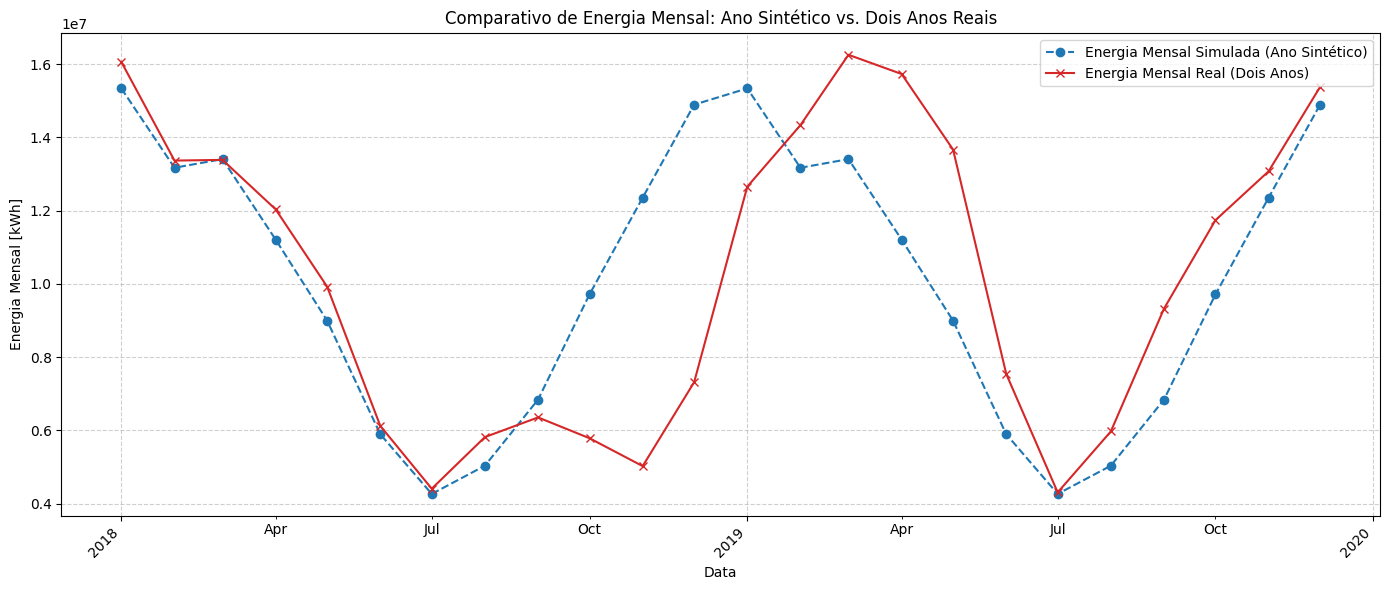

In [ ]:
# @title Comparativo de Energia Mensal (Simulada vs. Real)

# Ensure the index for the real data energy dataframe is datetime for proper plotting
df_energia_real.index = pd.to_datetime(df_energia_real.index)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot simulated monthly energy (synthetic year)
# We will repeat the synthetic year data to cover the two-year period for comparison
num_years_real = (df_energia_real.index.max().year - df_energia_real.index.min().year) + 1
simulated_dates = pd.date_range(start=df_energia_real.index.min(), periods=len(df_energia_real), freq='MS')

# Tile the synthetic year energy data to match the length of the real data
simulated_energy_tiled = pd.Series(np.tile(df_energia['Energia Mensal [kWh]'].values, num_years_real), index=simulated_dates)


ax.plot(simulated_energy_tiled.index, simulated_energy_tiled.values, marker='o', linestyle='--', label='Energia Mensal Simulada (Ano Sintético)', color='tab:blue')


# Plot real monthly energy (two real years)
ax.plot(df_energia_real.index, df_energia_real['Energia Mensal Real [kWh]'], marker='x', linestyle='-', label='Energia Mensal Real (Dois Anos)', color='tab:red')

# Formatting the plot
ax.set_title('Comparativo de Energia Mensal: Ano Sintético vs. Dois Anos Reais')
ax.set_xlabel('Data')
ax.set_ylabel('Energia Mensal [kWh]')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

# Improve date formatting on x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3)) # Show ticks every 3 months
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Conclusão

- **Viabilidade técnica:** O projeto para a implantação da hidrelétrica no **Rio Passo Fundo**, baseado na análise histórica de vazões entre 1973 e 2017, demonstrou ser viável.  
- **Metodologia:** O dimensionamento foi fundamentado na **série sintética**, utilizando a **vazão Q50** para a vazão regularizada, garantindo uma abordagem conservadora e robusta.  
- **Reservatório:** O dimensionamento atendeu ao volume útil requerido pelo **Diagrama de Rippl**, assegurando, pelos parâmetros geométricos *(a, b, c)*, o cumprimento da restrição de **volume mínimo (20% do total)** e a operação eficiente dos conjuntos turbina–gerador.  
- **Evaporação:** A ausência de dados locais foi superada pela aplicação do **modelo de Priestley–Taylor**, permitindo incorporar perdas por radiação e fornecer uma estimativa de **altura líquida mais realista**.  
- **Resultados energéticos:** A **Energia Anual Potencial (242 MWh)** apresentou-se próxima da **Garantia Energética real (245 MWh)**, validando a consistência do modelo.  
- **Limitações:** Algumas simplificações foram adotadas, como as perdas hidráulicas tratadas como **valor fixo**, indicando espaço para maior detalhamento futuro.  
- **Otimização estratégica:** A análise revelou potencial para instalação de um **conjunto turbina–gerador auxiliar**, capaz de aproveitar os picos de **vertimento (spill)** nos períodos úmidos. Essa estratégia pode aumentar o **fator de capacidade** e maximizar a receita do aproveitamento, tornando a operação mais eficiente no uso dos recursos hídricos.
